# Afriat

In [1]:
ood_seed = 5

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["time_cat"] = adata.obs["time_cat"].astype(str).astype(float).astype(int).astype(str).astype("category")
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [7]:
df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
availables = list(df[df>100].index)
availables, len(availables)

([('0', 'Pericentral', 'Control'),
  ('0', 'Periportal', 'Control'),
  ('12', 'Pericentral', 'Infected'),
  ('12', 'Pericentral', 'Uninfected'),
  ('12', 'Periportal', 'Infected'),
  ('12', 'Periportal', 'Uninfected'),
  ('2', 'Pericentral', 'Uninfected'),
  ('2', 'Periportal', 'Infected'),
  ('2', 'Periportal', 'Uninfected'),
  ('24', 'Pericentral', 'Infected'),
  ('24', 'Pericentral', 'Uninfected'),
  ('24', 'Periportal', 'Infected'),
  ('24', 'Periportal', 'Uninfected'),
  ('30', 'Pericentral', 'Infected'),
  ('30', 'Pericentral', 'Uninfected'),
  ('30', 'Periportal', 'Infected'),
  ('30', 'Periportal', 'Uninfected'),
  ('36', 'Pericentral', 'Infected'),
  ('36', 'Pericentral', 'Uninfected'),
  ('36', 'Periportal', 'Infected'),
  ('36', 'Periportal', 'Uninfected')],
 21)

In [8]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask

def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["time_cat"] == choice[0]) & (adata.obs["zone"] == choice[1]) & (adata.obs["status_control"] == choice[2]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

('12', 'Periportal', 'Uninfected')


Removed datapoint: 1900

train         13677
validation     3476
ood            1900
Name: split, dtype: int64

In [9]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [10]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="time_cat",
    control_group="0",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['zone', 'status_control'],
)

  0%|          | 0/19053 [00:00<?, ?it/s]

 45%|████▌     | 8646/19053 [00:00<00:00, 86448.95it/s]

 91%|█████████▏| 17402/19053 [00:00<00:00, 87098.13it/s]

100%|██████████| 19053/19053 [00:00<00:00, 86681.19it/s]

  0%|          | 0/19053 [00:00<?, ?it/s]

100%|██████████| 19053/19053 [00:00<00:00, 1034955.31it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [11]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [12]:
model.train(max_epochs=400)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 408.50it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:08<58:14,  8.76s/it]

Epoch 1/400:   0%|          | 1/400 [00:08<58:14,  8.76s/it, v_num=1, recon=3.97e+3, r2_mean=0.187, adv_loss=3.36, acc_pert=0.242, acc_zone=0.708, acc_status_control=0.442]

Epoch 2/400:   0%|          | 1/400 [00:08<58:14,  8.76s/it, v_num=1, recon=3.97e+3, r2_mean=0.187, adv_loss=3.36, acc_pert=0.242, acc_zone=0.708, acc_status_control=0.442]

Epoch 2/400:   0%|          | 2/400 [00:17<56:18,  8.49s/it, v_num=1, recon=3.97e+3, r2_mean=0.187, adv_loss=3.36, acc_pert=0.242, acc_zone=0.708, acc_status_control=0.442]

Epoch 2/400:   0%|          | 2/400 [00:17<56:18,  8.49s/it, v_num=1, recon=3.24e+3, r2_mean=0.599, adv_loss=2.95, acc_pert=0.33, acc_zone=0.808, acc_status_control=0.577] 

Epoch 3/400:   0%|          | 2/400 [00:17<56:18,  8.49s/it, v_num=1, recon=3.24e+3, r2_mean=0.599, adv_loss=2.95, acc_pert=0.33, acc_zone=0.808, acc_status_control=0.577]

Epoch 3/400:   1%|          | 3/400 [01:52<5:19:59, 48.36s/it, v_num=1, recon=3.24e+3, r2_mean=0.599, adv_loss=2.95, acc_pert=0.33, acc_zone=0.808, acc_status_control=0.577]

Epoch 3/400:   1%|          | 3/400 [01:52<5:19:59, 48.36s/it, v_num=1, recon=3.17e+3, r2_mean=0.706, adv_loss=2.81, acc_pert=0.367, acc_zone=0.818, acc_status_control=0.575]

Epoch 4/400:   1%|          | 3/400 [01:52<5:19:59, 48.36s/it, v_num=1, recon=3.17e+3, r2_mean=0.706, adv_loss=2.81, acc_pert=0.367, acc_zone=0.818, acc_status_control=0.575]

Epoch 4/400:   1%|          | 4/400 [02:00<3:34:07, 32.44s/it, v_num=1, recon=3.17e+3, r2_mean=0.706, adv_loss=2.81, acc_pert=0.367, acc_zone=0.818, acc_status_control=0.575]

Epoch 4/400:   1%|          | 4/400 [02:00<3:34:07, 32.44s/it, v_num=1, recon=3.15e+3, r2_mean=0.749, adv_loss=2.7, acc_pert=0.396, acc_zone=0.826, acc_status_control=0.571] 

Epoch 5/400:   1%|          | 4/400 [02:00<3:34:07, 32.44s/it, v_num=1, recon=3.15e+3, r2_mean=0.749, adv_loss=2.7, acc_pert=0.396, acc_zone=0.826, acc_status_control=0.571]

Epoch 5/400:   1%|▏         | 5/400 [02:09<2:35:50, 23.67s/it, v_num=1, recon=3.15e+3, r2_mean=0.749, adv_loss=2.7, acc_pert=0.396, acc_zone=0.826, acc_status_control=0.571]

Epoch 5/400:   1%|▏         | 5/400 [02:09<2:35:50, 23.67s/it, v_num=1, recon=3.14e+3, r2_mean=0.771, adv_loss=2.56, acc_pert=0.439, acc_zone=0.824, acc_status_control=0.583]

Epoch 6/400:   1%|▏         | 5/400 [02:09<2:35:50, 23.67s/it, v_num=1, recon=3.14e+3, r2_mean=0.771, adv_loss=2.56, acc_pert=0.439, acc_zone=0.824, acc_status_control=0.583]

Epoch 6/400:   2%|▏         | 6/400 [02:17<2:00:55, 18.41s/it, v_num=1, recon=3.14e+3, r2_mean=0.771, adv_loss=2.56, acc_pert=0.439, acc_zone=0.824, acc_status_control=0.583]

Epoch 6/400:   2%|▏         | 6/400 [02:17<2:00:55, 18.41s/it, v_num=1, recon=3.13e+3, r2_mean=0.787, adv_loss=2.41, acc_pert=0.487, acc_zone=0.821, acc_status_control=0.599]

Epoch 7/400:   2%|▏         | 6/400 [02:17<2:00:55, 18.41s/it, v_num=1, recon=3.13e+3, r2_mean=0.787, adv_loss=2.41, acc_pert=0.487, acc_zone=0.821, acc_status_control=0.599]

Epoch 7/400:   2%|▏         | 7/400 [02:25<1:39:06, 15.13s/it, v_num=1, recon=3.13e+3, r2_mean=0.787, adv_loss=2.41, acc_pert=0.487, acc_zone=0.821, acc_status_control=0.599]

Epoch 7/400:   2%|▏         | 7/400 [02:25<1:39:06, 15.13s/it, v_num=1, recon=3.12e+3, r2_mean=0.796, adv_loss=2.32, acc_pert=0.506, acc_zone=0.827, acc_status_control=0.6]  

Epoch 8/400:   2%|▏         | 7/400 [02:25<1:39:06, 15.13s/it, v_num=1, recon=3.12e+3, r2_mean=0.796, adv_loss=2.32, acc_pert=0.506, acc_zone=0.827, acc_status_control=0.6]

Epoch 8/400:   2%|▏         | 8/400 [02:33<1:24:34, 12.94s/it, v_num=1, recon=3.12e+3, r2_mean=0.796, adv_loss=2.32, acc_pert=0.506, acc_zone=0.827, acc_status_control=0.6]

Epoch 8/400:   2%|▏         | 8/400 [02:33<1:24:34, 12.94s/it, v_num=1, recon=3.11e+3, r2_mean=0.804, adv_loss=2.3, acc_pert=0.523, acc_zone=0.829, acc_status_control=0.595]

Epoch 9/400:   2%|▏         | 8/400 [02:33<1:24:34, 12.94s/it, v_num=1, recon=3.11e+3, r2_mean=0.804, adv_loss=2.3, acc_pert=0.523, acc_zone=0.829, acc_status_control=0.595]

Epoch 9/400:   2%|▏         | 9/400 [02:42<1:14:48, 11.48s/it, v_num=1, recon=3.11e+3, r2_mean=0.804, adv_loss=2.3, acc_pert=0.523, acc_zone=0.829, acc_status_control=0.595]

Epoch 9/400:   2%|▏         | 9/400 [02:42<1:14:48, 11.48s/it, v_num=1, recon=3.11e+3, r2_mean=0.807, adv_loss=2.25, acc_pert=0.549, acc_zone=0.832, acc_status_control=0.599]

Epoch 10/400:   2%|▏         | 9/400 [02:42<1:14:48, 11.48s/it, v_num=1, recon=3.11e+3, r2_mean=0.807, adv_loss=2.25, acc_pert=0.549, acc_zone=0.832, acc_status_control=0.599]


disnt_basal = 1.2521928442016228

disnt_after = 1.923376676583855

val_r2_mean = 0.8056538678814988

val_r2_var = 0.19202354309233602


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [03:44<2:57:11, 27.26s/it, v_num=1, recon=3.11e+3, r2_mean=0.807, adv_loss=2.25, acc_pert=0.549, acc_zone=0.832, acc_status_control=0.599]

Epoch 10/400:   2%|▎         | 10/400 [03:44<2:57:11, 27.26s/it, v_num=1, recon=3.1e+3, r2_mean=0.809, adv_loss=2.19, acc_pert=0.568, acc_zone=0.836, acc_status_control=0.596, val_recon=3.11e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.806, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [03:44<2:57:11, 27.26s/it, v_num=1, recon=3.1e+3, r2_mean=0.809, adv_loss=2.19, acc_pert=0.568, acc_zone=0.836, acc_status_control=0.596, val_recon=3.11e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.806, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [04:05<2:44:42, 25.40s/it, v_num=1, recon=3.1e+3, r2_mean=0.809, adv_loss=2.19, acc_pert=0.568, acc_zone=0.836, acc_status_control=0.596, val_recon=3.11e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.806, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [04:05<2:44:42, 25.40s/it, v_num=1, recon=3.09e+3, r2_mean=0.813, adv_loss=2.11, acc_pert=0.607, acc_zone=0.84, acc_status_control=0.604, val_recon=3.11e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.806, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [04:05<2:44:42, 25.40s/it, v_num=1, recon=3.09e+3, r2_mean=0.813, adv_loss=2.11, acc_pert=0.607, acc_zone=0.84, acc_status_control=0.604, val_recon=3.11e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.806, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [04:14<2:10:13, 20.14s/it, v_num=1, recon=3.09e+3, r2_mean=0.813, adv_loss=2.11, acc_pert=0.607, acc_zone=0.84, acc_status_control=0.604, val_recon=3.11e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.806, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [04:14<2:10:13, 20.14s/it, v_num=1, recon=3.09e+3, r2_mean=0.812, adv_loss=2.09, acc_pert=0.623, acc_zone=0.843, acc_status_control=0.607, val_recon=3.11e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.806, val_KL=nan]

Epoch 13/400:   3%|▎         | 12/400 [04:14<2:10:13, 20.14s/it, v_num=1, recon=3.09e+3, r2_mean=0.812, adv_loss=2.09, acc_pert=0.623, acc_zone=0.843, acc_status_control=0.607, val_recon=3.11e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.806, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [04:22<1:46:18, 16.48s/it, v_num=1, recon=3.09e+3, r2_mean=0.812, adv_loss=2.09, acc_pert=0.623, acc_zone=0.843, acc_status_control=0.607, val_recon=3.11e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.806, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [04:22<1:46:18, 16.48s/it, v_num=1, recon=3.08e+3, r2_mean=0.818, adv_loss=2.05, acc_pert=0.653, acc_zone=0.845, acc_status_control=0.605, val_recon=3.11e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.806, val_KL=nan]

Epoch 14/400:   3%|▎         | 13/400 [04:22<1:46:18, 16.48s/it, v_num=1, recon=3.08e+3, r2_mean=0.818, adv_loss=2.05, acc_pert=0.653, acc_zone=0.845, acc_status_control=0.605, val_recon=3.11e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.806, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [04:30<1:29:47, 13.96s/it, v_num=1, recon=3.08e+3, r2_mean=0.818, adv_loss=2.05, acc_pert=0.653, acc_zone=0.845, acc_status_control=0.605, val_recon=3.11e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.806, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [04:30<1:29:47, 13.96s/it, v_num=1, recon=3.08e+3, r2_mean=0.82, adv_loss=2.01, acc_pert=0.677, acc_zone=0.839, acc_status_control=0.606, val_recon=3.11e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.806, val_KL=nan] 

Epoch 15/400:   4%|▎         | 14/400 [04:30<1:29:47, 13.96s/it, v_num=1, recon=3.08e+3, r2_mean=0.82, adv_loss=2.01, acc_pert=0.677, acc_zone=0.839, acc_status_control=0.606, val_recon=3.11e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.806, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [04:38<1:18:25, 12.22s/it, v_num=1, recon=3.08e+3, r2_mean=0.82, adv_loss=2.01, acc_pert=0.677, acc_zone=0.839, acc_status_control=0.606, val_recon=3.11e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.806, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [04:38<1:18:25, 12.22s/it, v_num=1, recon=3.07e+3, r2_mean=0.821, adv_loss=1.99, acc_pert=0.683, acc_zone=0.844, acc_status_control=0.601, val_recon=3.11e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.806, val_KL=nan]

Epoch 16/400:   4%|▍         | 15/400 [04:38<1:18:25, 12.22s/it, v_num=1, recon=3.07e+3, r2_mean=0.821, adv_loss=1.99, acc_pert=0.683, acc_zone=0.844, acc_status_control=0.601, val_recon=3.11e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.806, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [04:46<1:10:32, 11.02s/it, v_num=1, recon=3.07e+3, r2_mean=0.821, adv_loss=1.99, acc_pert=0.683, acc_zone=0.844, acc_status_control=0.601, val_recon=3.11e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.806, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [04:46<1:10:32, 11.02s/it, v_num=1, recon=3.07e+3, r2_mean=0.822, adv_loss=2.01, acc_pert=0.679, acc_zone=0.84, acc_status_control=0.602, val_recon=3.11e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.806, val_KL=nan] 

Epoch 17/400:   4%|▍         | 16/400 [04:46<1:10:32, 11.02s/it, v_num=1, recon=3.07e+3, r2_mean=0.822, adv_loss=2.01, acc_pert=0.679, acc_zone=0.84, acc_status_control=0.602, val_recon=3.11e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.806, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [04:54<1:04:50, 10.16s/it, v_num=1, recon=3.07e+3, r2_mean=0.822, adv_loss=2.01, acc_pert=0.679, acc_zone=0.84, acc_status_control=0.602, val_recon=3.11e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.806, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [04:54<1:04:50, 10.16s/it, v_num=1, recon=3.06e+3, r2_mean=0.822, adv_loss=1.99, acc_pert=0.682, acc_zone=0.843, acc_status_control=0.606, val_recon=3.11e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.806, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [04:54<1:04:50, 10.16s/it, v_num=1, recon=3.06e+3, r2_mean=0.822, adv_loss=1.99, acc_pert=0.682, acc_zone=0.843, acc_status_control=0.606, val_recon=3.11e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.806, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [05:03<1:01:02,  9.59s/it, v_num=1, recon=3.06e+3, r2_mean=0.822, adv_loss=1.99, acc_pert=0.682, acc_zone=0.843, acc_status_control=0.606, val_recon=3.11e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.806, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [05:03<1:01:02,  9.59s/it, v_num=1, recon=3.06e+3, r2_mean=0.826, adv_loss=1.97, acc_pert=0.687, acc_zone=0.84, acc_status_control=0.608, val_recon=3.11e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.806, val_KL=nan] 

Epoch 19/400:   4%|▍         | 18/400 [05:03<1:01:02,  9.59s/it, v_num=1, recon=3.06e+3, r2_mean=0.826, adv_loss=1.97, acc_pert=0.687, acc_zone=0.84, acc_status_control=0.608, val_recon=3.11e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.806, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [05:39<1:52:32, 17.72s/it, v_num=1, recon=3.06e+3, r2_mean=0.826, adv_loss=1.97, acc_pert=0.687, acc_zone=0.84, acc_status_control=0.608, val_recon=3.11e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.806, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [05:39<1:52:32, 17.72s/it, v_num=1, recon=3.06e+3, r2_mean=0.827, adv_loss=1.97, acc_pert=0.695, acc_zone=0.836, acc_status_control=0.61, val_recon=3.11e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.806, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [05:39<1:52:32, 17.72s/it, v_num=1, recon=3.06e+3, r2_mean=0.827, adv_loss=1.97, acc_pert=0.695, acc_zone=0.836, acc_status_control=0.61, val_recon=3.11e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.806, val_KL=nan]


disnt_basal = 1.25886499957641

disnt_after = 1.8994335588590017

val_r2_mean = 0.8229664757092439

val_r2_var = 0.22405488731561002

Epoch 20/400:   5%|▌         | 20/400 [06:29<2:53:57, 27.47s/it, v_num=1, recon=3.06e+3, r2_mean=0.827, adv_loss=1.97, acc_pert=0.695, acc_zone=0.836, acc_status_control=0.61, val_recon=3.11e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.806, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [06:29<2:53:57, 27.47s/it, v_num=1, recon=3.05e+3, r2_mean=0.825, adv_loss=1.97, acc_pert=0.686, acc_zone=0.836, acc_status_control=0.618, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 21/400:   5%|▌         | 20/400 [06:29<2:53:57, 27.47s/it, v_num=1, recon=3.05e+3, r2_mean=0.825, adv_loss=1.97, acc_pert=0.686, acc_zone=0.836, acc_status_control=0.618, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [06:50<2:41:19, 25.54s/it, v_num=1, recon=3.05e+3, r2_mean=0.825, adv_loss=1.97, acc_pert=0.686, acc_zone=0.836, acc_status_control=0.618, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [06:50<2:41:19, 25.54s/it, v_num=1, recon=3.05e+3, r2_mean=0.827, adv_loss=1.98, acc_pert=0.687, acc_zone=0.838, acc_status_control=0.613, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 22/400:   5%|▌         | 21/400 [06:50<2:41:19, 25.54s/it, v_num=1, recon=3.05e+3, r2_mean=0.827, adv_loss=1.98, acc_pert=0.687, acc_zone=0.838, acc_status_control=0.613, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [06:59<2:08:04, 20.33s/it, v_num=1, recon=3.05e+3, r2_mean=0.827, adv_loss=1.98, acc_pert=0.687, acc_zone=0.838, acc_status_control=0.613, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [06:59<2:08:04, 20.33s/it, v_num=1, recon=3.05e+3, r2_mean=0.827, adv_loss=1.98, acc_pert=0.684, acc_zone=0.836, acc_status_control=0.617, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 23/400:   6%|▌         | 22/400 [06:59<2:08:04, 20.33s/it, v_num=1, recon=3.05e+3, r2_mean=0.827, adv_loss=1.98, acc_pert=0.684, acc_zone=0.836, acc_status_control=0.617, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [07:07<1:44:51, 16.69s/it, v_num=1, recon=3.05e+3, r2_mean=0.827, adv_loss=1.98, acc_pert=0.684, acc_zone=0.836, acc_status_control=0.617, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [07:07<1:44:51, 16.69s/it, v_num=1, recon=3.04e+3, r2_mean=0.828, adv_loss=1.99, acc_pert=0.681, acc_zone=0.836, acc_status_control=0.618, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [07:07<1:44:51, 16.69s/it, v_num=1, recon=3.04e+3, r2_mean=0.828, adv_loss=1.99, acc_pert=0.681, acc_zone=0.836, acc_status_control=0.618, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [07:15<1:28:41, 14.15s/it, v_num=1, recon=3.04e+3, r2_mean=0.828, adv_loss=1.99, acc_pert=0.681, acc_zone=0.836, acc_status_control=0.618, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [07:15<1:28:41, 14.15s/it, v_num=1, recon=3.04e+3, r2_mean=0.828, adv_loss=1.98, acc_pert=0.681, acc_zone=0.839, acc_status_control=0.629, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 25/400:   6%|▌         | 24/400 [07:15<1:28:41, 14.15s/it, v_num=1, recon=3.04e+3, r2_mean=0.828, adv_loss=1.98, acc_pert=0.681, acc_zone=0.839, acc_status_control=0.629, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [07:23<1:17:19, 12.37s/it, v_num=1, recon=3.04e+3, r2_mean=0.828, adv_loss=1.98, acc_pert=0.681, acc_zone=0.839, acc_status_control=0.629, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [07:23<1:17:19, 12.37s/it, v_num=1, recon=3.04e+3, r2_mean=0.828, adv_loss=1.99, acc_pert=0.681, acc_zone=0.838, acc_status_control=0.625, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [07:23<1:17:19, 12.37s/it, v_num=1, recon=3.04e+3, r2_mean=0.828, adv_loss=1.99, acc_pert=0.681, acc_zone=0.838, acc_status_control=0.625, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [07:37<1:19:03, 12.68s/it, v_num=1, recon=3.04e+3, r2_mean=0.828, adv_loss=1.99, acc_pert=0.681, acc_zone=0.838, acc_status_control=0.625, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [07:37<1:19:03, 12.68s/it, v_num=1, recon=3.03e+3, r2_mean=0.827, adv_loss=1.99, acc_pert=0.67, acc_zone=0.838, acc_status_control=0.63, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]  

Epoch 27/400:   6%|▋         | 26/400 [07:37<1:19:03, 12.68s/it, v_num=1, recon=3.03e+3, r2_mean=0.827, adv_loss=1.99, acc_pert=0.67, acc_zone=0.838, acc_status_control=0.63, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [07:45<1:10:46, 11.39s/it, v_num=1, recon=3.03e+3, r2_mean=0.827, adv_loss=1.99, acc_pert=0.67, acc_zone=0.838, acc_status_control=0.63, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [07:45<1:10:46, 11.39s/it, v_num=1, recon=3.03e+3, r2_mean=0.827, adv_loss=1.99, acc_pert=0.677, acc_zone=0.836, acc_status_control=0.625, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [07:45<1:10:46, 11.39s/it, v_num=1, recon=3.03e+3, r2_mean=0.827, adv_loss=1.99, acc_pert=0.677, acc_zone=0.836, acc_status_control=0.625, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [07:53<1:04:45, 10.44s/it, v_num=1, recon=3.03e+3, r2_mean=0.827, adv_loss=1.99, acc_pert=0.677, acc_zone=0.836, acc_status_control=0.625, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [07:53<1:04:45, 10.44s/it, v_num=1, recon=3.03e+3, r2_mean=0.83, adv_loss=2, acc_pert=0.671, acc_zone=0.836, acc_status_control=0.622, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]    

Epoch 29/400:   7%|▋         | 28/400 [07:53<1:04:45, 10.44s/it, v_num=1, recon=3.03e+3, r2_mean=0.83, adv_loss=2, acc_pert=0.671, acc_zone=0.836, acc_status_control=0.622, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [08:02<1:00:31,  9.79s/it, v_num=1, recon=3.03e+3, r2_mean=0.83, adv_loss=2, acc_pert=0.671, acc_zone=0.836, acc_status_control=0.622, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [08:02<1:00:31,  9.79s/it, v_num=1, recon=3.02e+3, r2_mean=0.829, adv_loss=2, acc_pert=0.671, acc_zone=0.835, acc_status_control=0.623, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 30/400:   7%|▋         | 29/400 [08:02<1:00:31,  9.79s/it, v_num=1, recon=3.02e+3, r2_mean=0.829, adv_loss=2, acc_pert=0.671, acc_zone=0.835, acc_status_control=0.623, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]


disnt_basal = 1.2425678126866242

disnt_after = 1.8867755578136662

val_r2_mean = 0.8282557287684956

val_r2_var = 0.25295449134578224

Epoch 30/400:   8%|▊         | 30/400 [08:43<1:58:32, 19.22s/it, v_num=1, recon=3.02e+3, r2_mean=0.829, adv_loss=2, acc_pert=0.671, acc_zone=0.835, acc_status_control=0.623, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [08:43<1:58:32, 19.22s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=2.03, acc_pert=0.664, acc_zone=0.836, acc_status_control=0.627, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [08:43<1:58:32, 19.22s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=2.03, acc_pert=0.664, acc_zone=0.836, acc_status_control=0.627, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [09:37<3:02:27, 29.67s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=2.03, acc_pert=0.664, acc_zone=0.836, acc_status_control=0.627, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [09:37<3:02:27, 29.67s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.04, acc_pert=0.661, acc_zone=0.837, acc_status_control=0.622, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [09:37<3:02:27, 29.67s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.04, acc_pert=0.661, acc_zone=0.837, acc_status_control=0.622, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [09:45<2:22:26, 23.23s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.04, acc_pert=0.661, acc_zone=0.837, acc_status_control=0.622, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [09:45<2:22:26, 23.23s/it, v_num=1, recon=3.02e+3, r2_mean=0.831, adv_loss=2.04, acc_pert=0.666, acc_zone=0.831, acc_status_control=0.622, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 33/400:   8%|▊         | 32/400 [09:45<2:22:26, 23.23s/it, v_num=1, recon=3.02e+3, r2_mean=0.831, adv_loss=2.04, acc_pert=0.666, acc_zone=0.831, acc_status_control=0.622, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [09:53<1:54:16, 18.68s/it, v_num=1, recon=3.02e+3, r2_mean=0.831, adv_loss=2.04, acc_pert=0.666, acc_zone=0.831, acc_status_control=0.622, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [09:53<1:54:16, 18.68s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=2.03, acc_pert=0.668, acc_zone=0.83, acc_status_control=0.624, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan] 

Epoch 34/400:   8%|▊         | 33/400 [09:53<1:54:16, 18.68s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=2.03, acc_pert=0.668, acc_zone=0.83, acc_status_control=0.624, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [10:01<1:34:34, 15.50s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=2.03, acc_pert=0.668, acc_zone=0.83, acc_status_control=0.624, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [10:01<1:34:34, 15.50s/it, v_num=1, recon=3.01e+3, r2_mean=0.833, adv_loss=2.05, acc_pert=0.662, acc_zone=0.834, acc_status_control=0.621, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [10:01<1:34:34, 15.50s/it, v_num=1, recon=3.01e+3, r2_mean=0.833, adv_loss=2.05, acc_pert=0.662, acc_zone=0.834, acc_status_control=0.621, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [10:09<1:20:55, 13.30s/it, v_num=1, recon=3.01e+3, r2_mean=0.833, adv_loss=2.05, acc_pert=0.662, acc_zone=0.834, acc_status_control=0.621, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [10:09<1:20:55, 13.30s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=2.05, acc_pert=0.658, acc_zone=0.832, acc_status_control=0.621, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 36/400:   9%|▉         | 35/400 [10:09<1:20:55, 13.30s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=2.05, acc_pert=0.658, acc_zone=0.832, acc_status_control=0.621, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [10:18<1:11:31, 11.79s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=2.05, acc_pert=0.658, acc_zone=0.832, acc_status_control=0.621, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [10:18<1:11:31, 11.79s/it, v_num=1, recon=3.01e+3, r2_mean=0.832, adv_loss=2.06, acc_pert=0.652, acc_zone=0.833, acc_status_control=0.626, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [10:18<1:11:31, 11.79s/it, v_num=1, recon=3.01e+3, r2_mean=0.832, adv_loss=2.06, acc_pert=0.652, acc_zone=0.833, acc_status_control=0.626, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [10:26<1:04:47, 10.71s/it, v_num=1, recon=3.01e+3, r2_mean=0.832, adv_loss=2.06, acc_pert=0.652, acc_zone=0.833, acc_status_control=0.626, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [10:26<1:04:47, 10.71s/it, v_num=1, recon=3e+3, r2_mean=0.832, adv_loss=2.08, acc_pert=0.65, acc_zone=0.828, acc_status_control=0.624, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]    

Epoch 38/400:   9%|▉         | 37/400 [10:26<1:04:47, 10.71s/it, v_num=1, recon=3e+3, r2_mean=0.832, adv_loss=2.08, acc_pert=0.65, acc_zone=0.828, acc_status_control=0.624, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [10:34<1:00:01,  9.95s/it, v_num=1, recon=3e+3, r2_mean=0.832, adv_loss=2.08, acc_pert=0.65, acc_zone=0.828, acc_status_control=0.624, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [10:34<1:00:01,  9.95s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=2.08, acc_pert=0.649, acc_zone=0.827, acc_status_control=0.618, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [10:34<1:00:01,  9.95s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=2.08, acc_pert=0.649, acc_zone=0.827, acc_status_control=0.618, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [10:42<56:40,  9.42s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=2.08, acc_pert=0.649, acc_zone=0.827, acc_status_control=0.618, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]  

Epoch 39/400:  10%|▉         | 39/400 [10:42<56:40,  9.42s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=2.1, acc_pert=0.643, acc_zone=0.829, acc_status_control=0.622, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan] 

Epoch 40/400:  10%|▉         | 39/400 [10:42<56:40,  9.42s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=2.1, acc_pert=0.643, acc_zone=0.829, acc_status_control=0.622, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]


disnt_basal = 1.2370841834933712

disnt_after = 1.8881644812738612

val_r2_mean = 0.827725426943757

val_r2_var = 0.2646038396127263


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [11:17<1:42:43, 17.12s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=2.1, acc_pert=0.643, acc_zone=0.829, acc_status_control=0.622, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [11:17<1:42:43, 17.12s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=2.09, acc_pert=0.634, acc_zone=0.831, acc_status_control=0.621, val_recon=3.02e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 41/400:  10%|█         | 40/400 [11:17<1:42:43, 17.12s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=2.09, acc_pert=0.634, acc_zone=0.831, acc_status_control=0.621, val_recon=3.02e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [11:41<1:55:08, 19.24s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=2.09, acc_pert=0.634, acc_zone=0.831, acc_status_control=0.621, val_recon=3.02e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [11:41<1:55:08, 19.24s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=2.12, acc_pert=0.632, acc_zone=0.828, acc_status_control=0.618, val_recon=3.02e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 42/400:  10%|█         | 41/400 [11:41<1:55:08, 19.24s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=2.12, acc_pert=0.632, acc_zone=0.828, acc_status_control=0.618, val_recon=3.02e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [11:49<1:34:45, 15.88s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=2.12, acc_pert=0.632, acc_zone=0.828, acc_status_control=0.618, val_recon=3.02e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [11:49<1:34:45, 15.88s/it, v_num=1, recon=2.99e+3, r2_mean=0.833, adv_loss=2.12, acc_pert=0.631, acc_zone=0.829, acc_status_control=0.615, val_recon=3.02e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [11:49<1:34:45, 15.88s/it, v_num=1, recon=2.99e+3, r2_mean=0.833, adv_loss=2.12, acc_pert=0.631, acc_zone=0.829, acc_status_control=0.615, val_recon=3.02e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [11:58<1:20:46, 13.58s/it, v_num=1, recon=2.99e+3, r2_mean=0.833, adv_loss=2.12, acc_pert=0.631, acc_zone=0.829, acc_status_control=0.615, val_recon=3.02e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [11:58<1:20:46, 13.58s/it, v_num=1, recon=2.99e+3, r2_mean=0.833, adv_loss=2.13, acc_pert=0.632, acc_zone=0.829, acc_status_control=0.622, val_recon=3.02e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [11:58<1:20:46, 13.58s/it, v_num=1, recon=2.99e+3, r2_mean=0.833, adv_loss=2.13, acc_pert=0.632, acc_zone=0.829, acc_status_control=0.622, val_recon=3.02e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [12:06<1:11:01, 11.97s/it, v_num=1, recon=2.99e+3, r2_mean=0.833, adv_loss=2.13, acc_pert=0.632, acc_zone=0.829, acc_status_control=0.622, val_recon=3.02e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [12:06<1:11:01, 11.97s/it, v_num=1, recon=2.99e+3, r2_mean=0.835, adv_loss=2.13, acc_pert=0.626, acc_zone=0.827, acc_status_control=0.616, val_recon=3.02e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [12:06<1:11:01, 11.97s/it, v_num=1, recon=2.99e+3, r2_mean=0.835, adv_loss=2.13, acc_pert=0.626, acc_zone=0.827, acc_status_control=0.616, val_recon=3.02e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [12:14<1:04:12, 10.85s/it, v_num=1, recon=2.99e+3, r2_mean=0.835, adv_loss=2.13, acc_pert=0.626, acc_zone=0.827, acc_status_control=0.616, val_recon=3.02e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [12:14<1:04:12, 10.85s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.14, acc_pert=0.618, acc_zone=0.83, acc_status_control=0.615, val_recon=3.02e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan] 

Epoch 46/400:  11%|█▏        | 45/400 [12:14<1:04:12, 10.85s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.14, acc_pert=0.618, acc_zone=0.83, acc_status_control=0.615, val_recon=3.02e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [12:22<59:17, 10.05s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.14, acc_pert=0.618, acc_zone=0.83, acc_status_control=0.615, val_recon=3.02e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]  

Epoch 46/400:  12%|█▏        | 46/400 [12:22<59:17, 10.05s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.15, acc_pert=0.615, acc_zone=0.829, acc_status_control=0.619, val_recon=3.02e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [12:22<59:17, 10.05s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.15, acc_pert=0.615, acc_zone=0.829, acc_status_control=0.619, val_recon=3.02e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [12:31<55:50,  9.49s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.15, acc_pert=0.615, acc_zone=0.829, acc_status_control=0.619, val_recon=3.02e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [12:31<55:50,  9.49s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.16, acc_pert=0.616, acc_zone=0.828, acc_status_control=0.618, val_recon=3.02e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [12:31<55:50,  9.49s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.16, acc_pert=0.616, acc_zone=0.828, acc_status_control=0.618, val_recon=3.02e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [12:39<53:21,  9.09s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.16, acc_pert=0.616, acc_zone=0.828, acc_status_control=0.618, val_recon=3.02e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [12:39<53:21,  9.09s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.17, acc_pert=0.609, acc_zone=0.825, acc_status_control=0.621, val_recon=3.02e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [12:39<53:21,  9.09s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.17, acc_pert=0.609, acc_zone=0.825, acc_status_control=0.621, val_recon=3.02e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [12:47<51:34,  8.82s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.17, acc_pert=0.609, acc_zone=0.825, acc_status_control=0.621, val_recon=3.02e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [12:47<51:34,  8.82s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.17, acc_pert=0.61, acc_zone=0.827, acc_status_control=0.614, val_recon=3.02e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan] 

Epoch 50/400:  12%|█▏        | 49/400 [12:47<51:34,  8.82s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.17, acc_pert=0.61, acc_zone=0.827, acc_status_control=0.614, val_recon=3.02e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]


disnt_basal = 1.2243683979338567

disnt_after = 1.8828124163309663

val_r2_mean = 0.8306244776555219

val_r2_var = 0.2736364764092038


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [13:42<2:12:22, 22.69s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.17, acc_pert=0.61, acc_zone=0.827, acc_status_control=0.614, val_recon=3.02e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [13:42<2:12:22, 22.69s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.18, acc_pert=0.606, acc_zone=0.825, acc_status_control=0.613, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]  

Epoch 51/400:  12%|█▎        | 50/400 [13:42<2:12:22, 22.69s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.18, acc_pert=0.606, acc_zone=0.825, acc_status_control=0.613, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [14:20<2:38:23, 27.23s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.18, acc_pert=0.606, acc_zone=0.825, acc_status_control=0.613, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [14:20<2:38:23, 27.23s/it, v_num=1, recon=2.97e+3, r2_mean=0.832, adv_loss=2.18, acc_pert=0.602, acc_zone=0.828, acc_status_control=0.613, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [14:20<2:38:23, 27.23s/it, v_num=1, recon=2.97e+3, r2_mean=0.832, adv_loss=2.18, acc_pert=0.602, acc_zone=0.828, acc_status_control=0.613, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [14:28<2:04:59, 21.55s/it, v_num=1, recon=2.97e+3, r2_mean=0.832, adv_loss=2.18, acc_pert=0.602, acc_zone=0.828, acc_status_control=0.613, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [14:28<2:04:59, 21.55s/it, v_num=1, recon=2.97e+3, r2_mean=0.837, adv_loss=2.18, acc_pert=0.607, acc_zone=0.826, acc_status_control=0.614, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [14:28<2:04:59, 21.55s/it, v_num=1, recon=2.97e+3, r2_mean=0.837, adv_loss=2.18, acc_pert=0.607, acc_zone=0.826, acc_status_control=0.614, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [14:36<1:41:41, 17.58s/it, v_num=1, recon=2.97e+3, r2_mean=0.837, adv_loss=2.18, acc_pert=0.607, acc_zone=0.826, acc_status_control=0.614, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [14:36<1:41:41, 17.58s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.19, acc_pert=0.602, acc_zone=0.829, acc_status_control=0.617, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 54/400:  13%|█▎        | 53/400 [14:36<1:41:41, 17.58s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.19, acc_pert=0.602, acc_zone=0.829, acc_status_control=0.617, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [14:45<1:25:20, 14.80s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.19, acc_pert=0.602, acc_zone=0.829, acc_status_control=0.617, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [14:45<1:25:20, 14.80s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.19, acc_pert=0.596, acc_zone=0.827, acc_status_control=0.613, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [14:45<1:25:20, 14.80s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.19, acc_pert=0.596, acc_zone=0.827, acc_status_control=0.613, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [14:53<1:13:52, 12.85s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.19, acc_pert=0.596, acc_zone=0.827, acc_status_control=0.613, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [14:53<1:13:52, 12.85s/it, v_num=1, recon=2.97e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.604, acc_zone=0.825, acc_status_control=0.615, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [14:53<1:13:52, 12.85s/it, v_num=1, recon=2.97e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.604, acc_zone=0.825, acc_status_control=0.615, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [15:01<1:05:50, 11.48s/it, v_num=1, recon=2.97e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.604, acc_zone=0.825, acc_status_control=0.615, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [15:01<1:05:50, 11.48s/it, v_num=1, recon=2.96e+3, r2_mean=0.835, adv_loss=2.17, acc_pert=0.61, acc_zone=0.826, acc_status_control=0.62, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]  

Epoch 57/400:  14%|█▍        | 56/400 [15:01<1:05:50, 11.48s/it, v_num=1, recon=2.96e+3, r2_mean=0.835, adv_loss=2.17, acc_pert=0.61, acc_zone=0.826, acc_status_control=0.62, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [15:10<1:00:15, 10.54s/it, v_num=1, recon=2.96e+3, r2_mean=0.835, adv_loss=2.17, acc_pert=0.61, acc_zone=0.826, acc_status_control=0.62, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [15:10<1:00:15, 10.54s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.19, acc_pert=0.6, acc_zone=0.822, acc_status_control=0.618, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [15:10<1:00:15, 10.54s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.19, acc_pert=0.6, acc_zone=0.822, acc_status_control=0.618, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [15:18<56:18,  9.88s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.19, acc_pert=0.6, acc_zone=0.822, acc_status_control=0.618, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]  

Epoch 58/400:  14%|█▍        | 58/400 [15:18<56:18,  9.88s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.2, acc_pert=0.598, acc_zone=0.826, acc_status_control=0.614, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [15:18<56:18,  9.88s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.2, acc_pert=0.598, acc_zone=0.826, acc_status_control=0.614, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [15:26<53:35,  9.43s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.2, acc_pert=0.598, acc_zone=0.826, acc_status_control=0.614, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [15:26<53:35,  9.43s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.2, acc_pert=0.6, acc_zone=0.825, acc_status_control=0.615, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]  

Epoch 60/400:  15%|█▍        | 59/400 [15:26<53:35,  9.43s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.2, acc_pert=0.6, acc_zone=0.825, acc_status_control=0.615, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.2252494532511877

disnt_after = 1.88435693550911

val_r2_mean = 0.8299960333788814

val_r2_var = 0.2873712375750977


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [16:22<2:12:06, 23.31s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.2, acc_pert=0.6, acc_zone=0.825, acc_status_control=0.615, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [16:22<2:12:06, 23.31s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.19, acc_pert=0.6, acc_zone=0.823, acc_status_control=0.614, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 61/400:  15%|█▌        | 60/400 [16:22<2:12:06, 23.31s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.19, acc_pert=0.6, acc_zone=0.823, acc_status_control=0.614, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [16:31<1:47:54, 19.10s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.19, acc_pert=0.6, acc_zone=0.823, acc_status_control=0.614, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [16:31<1:47:54, 19.10s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.2, acc_pert=0.601, acc_zone=0.824, acc_status_control=0.619, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [16:31<1:47:54, 19.10s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.2, acc_pert=0.601, acc_zone=0.824, acc_status_control=0.619, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [16:39<1:29:07, 15.82s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.2, acc_pert=0.601, acc_zone=0.824, acc_status_control=0.619, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [16:39<1:29:07, 15.82s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.21, acc_pert=0.599, acc_zone=0.826, acc_status_control=0.617, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [16:39<1:29:07, 15.82s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.21, acc_pert=0.599, acc_zone=0.826, acc_status_control=0.617, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [16:48<1:16:18, 13.59s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.21, acc_pert=0.599, acc_zone=0.826, acc_status_control=0.617, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [16:48<1:16:18, 13.59s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.21, acc_pert=0.595, acc_zone=0.82, acc_status_control=0.615, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan] 

Epoch 64/400:  16%|█▌        | 63/400 [16:48<1:16:18, 13.59s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.21, acc_pert=0.595, acc_zone=0.82, acc_status_control=0.615, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [16:56<1:07:06, 11.98s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.21, acc_pert=0.595, acc_zone=0.82, acc_status_control=0.615, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [16:56<1:07:06, 11.98s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.22, acc_pert=0.59, acc_zone=0.823, acc_status_control=0.613, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [16:56<1:07:06, 11.98s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.22, acc_pert=0.59, acc_zone=0.823, acc_status_control=0.613, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [17:04<1:00:41, 10.87s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.22, acc_pert=0.59, acc_zone=0.823, acc_status_control=0.613, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [17:04<1:00:41, 10.87s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.586, acc_zone=0.823, acc_status_control=0.619, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 66/400:  16%|█▋        | 65/400 [17:04<1:00:41, 10.87s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.586, acc_zone=0.823, acc_status_control=0.619, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [17:13<56:05, 10.08s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.586, acc_zone=0.823, acc_status_control=0.619, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]  

Epoch 66/400:  16%|█▋        | 66/400 [17:13<56:05, 10.08s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.21, acc_pert=0.594, acc_zone=0.824, acc_status_control=0.615, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [17:13<56:05, 10.08s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.21, acc_pert=0.594, acc_zone=0.824, acc_status_control=0.615, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [17:21<52:57,  9.54s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.21, acc_pert=0.594, acc_zone=0.824, acc_status_control=0.615, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [17:21<52:57,  9.54s/it, v_num=1, recon=2.94e+3, r2_mean=0.834, adv_loss=2.23, acc_pert=0.592, acc_zone=0.824, acc_status_control=0.613, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [17:21<52:57,  9.54s/it, v_num=1, recon=2.94e+3, r2_mean=0.834, adv_loss=2.23, acc_pert=0.592, acc_zone=0.824, acc_status_control=0.613, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [17:29<50:40,  9.16s/it, v_num=1, recon=2.94e+3, r2_mean=0.834, adv_loss=2.23, acc_pert=0.592, acc_zone=0.824, acc_status_control=0.613, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [17:29<50:40,  9.16s/it, v_num=1, recon=2.94e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.591, acc_zone=0.827, acc_status_control=0.619, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan] 

Epoch 69/400:  17%|█▋        | 68/400 [17:29<50:40,  9.16s/it, v_num=1, recon=2.94e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.591, acc_zone=0.827, acc_status_control=0.619, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [17:37<49:01,  8.89s/it, v_num=1, recon=2.94e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.591, acc_zone=0.827, acc_status_control=0.619, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [17:37<49:01,  8.89s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.23, acc_pert=0.588, acc_zone=0.822, acc_status_control=0.615, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 70/400:  17%|█▋        | 69/400 [17:37<49:01,  8.89s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.23, acc_pert=0.588, acc_zone=0.822, acc_status_control=0.615, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.2222974537892994

disnt_after = 1.8834954325973647

val_r2_mean = 0.8273351878901085

val_r2_var = 0.2673022622763181

Epoch 70/400:  18%|█▊        | 70/400 [18:38<2:14:43, 24.49s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.23, acc_pert=0.588, acc_zone=0.822, acc_status_control=0.615, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [18:38<2:14:43, 24.49s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.23, acc_pert=0.589, acc_zone=0.828, acc_status_control=0.616, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 71/400:  18%|█▊        | 70/400 [18:38<2:14:43, 24.49s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.23, acc_pert=0.589, acc_zone=0.828, acc_status_control=0.616, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [18:50<1:53:34, 20.71s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.23, acc_pert=0.589, acc_zone=0.828, acc_status_control=0.616, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [18:50<1:53:34, 20.71s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.23, acc_pert=0.582, acc_zone=0.821, acc_status_control=0.613, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 72/400:  18%|█▊        | 71/400 [18:50<1:53:34, 20.71s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.23, acc_pert=0.582, acc_zone=0.821, acc_status_control=0.613, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [18:58<1:32:48, 16.98s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.23, acc_pert=0.582, acc_zone=0.821, acc_status_control=0.613, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [18:58<1:32:48, 16.98s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.24, acc_pert=0.583, acc_zone=0.824, acc_status_control=0.615, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [18:58<1:32:48, 16.98s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.24, acc_pert=0.583, acc_zone=0.824, acc_status_control=0.615, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [19:32<2:00:19, 22.08s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.24, acc_pert=0.583, acc_zone=0.824, acc_status_control=0.615, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [19:32<2:00:19, 22.08s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.23, acc_pert=0.583, acc_zone=0.825, acc_status_control=0.617, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [19:32<2:00:19, 22.08s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.23, acc_pert=0.583, acc_zone=0.825, acc_status_control=0.617, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [19:41<1:37:38, 17.97s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.23, acc_pert=0.583, acc_zone=0.825, acc_status_control=0.617, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [19:41<1:37:38, 17.97s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.24, acc_pert=0.588, acc_zone=0.823, acc_status_control=0.614, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [19:41<1:37:38, 17.97s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.24, acc_pert=0.588, acc_zone=0.823, acc_status_control=0.614, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [19:49<1:22:02, 15.15s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.24, acc_pert=0.588, acc_zone=0.823, acc_status_control=0.614, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [19:49<1:22:02, 15.15s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.24, acc_pert=0.578, acc_zone=0.823, acc_status_control=0.614, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [19:49<1:22:02, 15.15s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.24, acc_pert=0.578, acc_zone=0.823, acc_status_control=0.614, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [19:58<1:10:47, 13.11s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.24, acc_pert=0.578, acc_zone=0.823, acc_status_control=0.614, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [19:58<1:10:47, 13.11s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.58, acc_zone=0.819, acc_status_control=0.616, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan] 

Epoch 77/400:  19%|█▉        | 76/400 [19:58<1:10:47, 13.11s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.58, acc_zone=0.819, acc_status_control=0.616, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [20:06<1:02:48, 11.67s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.58, acc_zone=0.819, acc_status_control=0.616, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [20:06<1:02:48, 11.67s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.24, acc_pert=0.583, acc_zone=0.821, acc_status_control=0.618, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [20:06<1:02:48, 11.67s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.24, acc_pert=0.583, acc_zone=0.821, acc_status_control=0.618, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [20:15<57:43, 10.76s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.24, acc_pert=0.583, acc_zone=0.821, acc_status_control=0.618, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]  

Epoch 78/400:  20%|█▉        | 78/400 [20:15<57:43, 10.76s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.24, acc_pert=0.583, acc_zone=0.82, acc_status_control=0.617, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan] 

Epoch 79/400:  20%|█▉        | 78/400 [20:15<57:43, 10.76s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.24, acc_pert=0.583, acc_zone=0.82, acc_status_control=0.617, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [20:23<53:44, 10.04s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.24, acc_pert=0.583, acc_zone=0.82, acc_status_control=0.617, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [20:23<53:44, 10.04s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.25, acc_pert=0.576, acc_zone=0.82, acc_status_control=0.617, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 80/400:  20%|█▉        | 79/400 [20:23<53:44, 10.04s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.25, acc_pert=0.576, acc_zone=0.82, acc_status_control=0.617, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.2188120574064365

disnt_after = 1.8814171840227296

val_r2_mean = 0.8301081454514884

val_r2_var = 0.2917494267488278


Epoch 00079: cpa_metric reached. Module best state updated.


Epoch 80/400:  20%|██        | 80/400 [21:17<2:04:32, 23.35s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.25, acc_pert=0.576, acc_zone=0.82, acc_status_control=0.617, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [21:17<2:04:32, 23.35s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.24, acc_pert=0.584, acc_zone=0.822, acc_status_control=0.62, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan] 

Epoch 81/400:  20%|██        | 80/400 [21:17<2:04:32, 23.35s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.24, acc_pert=0.584, acc_zone=0.822, acc_status_control=0.62, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [21:26<1:39:56, 18.80s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.24, acc_pert=0.584, acc_zone=0.822, acc_status_control=0.62, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [21:26<1:39:56, 18.80s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.25, acc_pert=0.578, acc_zone=0.822, acc_status_control=0.614, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 82/400:  20%|██        | 81/400 [21:26<1:39:56, 18.80s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.25, acc_pert=0.578, acc_zone=0.822, acc_status_control=0.614, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [21:34<1:22:46, 15.62s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.25, acc_pert=0.578, acc_zone=0.822, acc_status_control=0.614, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [21:34<1:22:46, 15.62s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.25, acc_pert=0.575, acc_zone=0.821, acc_status_control=0.615, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [21:34<1:22:46, 15.62s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.25, acc_pert=0.575, acc_zone=0.821, acc_status_control=0.615, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [21:42<1:10:51, 13.41s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.25, acc_pert=0.575, acc_zone=0.821, acc_status_control=0.615, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [21:42<1:10:51, 13.41s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.58, acc_zone=0.822, acc_status_control=0.615, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan] 

Epoch 84/400:  21%|██        | 83/400 [21:42<1:10:51, 13.41s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.58, acc_zone=0.822, acc_status_control=0.615, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [21:50<1:02:19, 11.84s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.58, acc_zone=0.822, acc_status_control=0.615, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [21:50<1:02:19, 11.84s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.579, acc_zone=0.821, acc_status_control=0.617, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [21:50<1:02:19, 11.84s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.579, acc_zone=0.821, acc_status_control=0.617, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [21:59<56:35, 10.78s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.579, acc_zone=0.821, acc_status_control=0.617, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]  

Epoch 85/400:  21%|██▏       | 85/400 [21:59<56:35, 10.78s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.24, acc_pert=0.581, acc_zone=0.823, acc_status_control=0.617, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 86/400:  21%|██▏       | 85/400 [21:59<56:35, 10.78s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.24, acc_pert=0.581, acc_zone=0.823, acc_status_control=0.617, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [22:07<52:27, 10.03s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.24, acc_pert=0.581, acc_zone=0.823, acc_status_control=0.617, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [22:07<52:27, 10.03s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.571, acc_zone=0.82, acc_status_control=0.62, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]   

Epoch 87/400:  22%|██▏       | 86/400 [22:07<52:27, 10.03s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.571, acc_zone=0.82, acc_status_control=0.62, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [22:15<49:35,  9.51s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.571, acc_zone=0.82, acc_status_control=0.62, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [22:15<49:35,  9.51s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.578, acc_zone=0.822, acc_status_control=0.614, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 88/400:  22%|██▏       | 87/400 [22:15<49:35,  9.51s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.578, acc_zone=0.822, acc_status_control=0.614, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [22:23<47:32,  9.14s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.578, acc_zone=0.822, acc_status_control=0.614, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [22:23<47:32,  9.14s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.573, acc_zone=0.825, acc_status_control=0.616, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [22:23<47:32,  9.14s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.573, acc_zone=0.825, acc_status_control=0.616, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [22:32<46:04,  8.89s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.573, acc_zone=0.825, acc_status_control=0.616, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [22:32<46:04,  8.89s/it, v_num=1, recon=2.91e+3, r2_mean=0.835, adv_loss=2.25, acc_pert=0.575, acc_zone=0.821, acc_status_control=0.617, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [22:32<46:04,  8.89s/it, v_num=1, recon=2.91e+3, r2_mean=0.835, adv_loss=2.25, acc_pert=0.575, acc_zone=0.821, acc_status_control=0.617, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.2200847542160376

disnt_after = 1.8869585761578125

val_r2_mean = 0.8303672734035672

val_r2_var = 0.2901730838238064


Epoch 00089: cpa_metric reached. Module best state updated.


Epoch 90/400:  22%|██▎       | 90/400 [23:34<2:08:58, 24.96s/it, v_num=1, recon=2.91e+3, r2_mean=0.835, adv_loss=2.25, acc_pert=0.575, acc_zone=0.821, acc_status_control=0.617, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [23:34<2:08:58, 24.96s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.562, acc_zone=0.822, acc_status_control=0.617, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 91/400:  22%|██▎       | 90/400 [23:34<2:08:58, 24.96s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.562, acc_zone=0.822, acc_status_control=0.617, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [23:50<1:54:38, 22.26s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.562, acc_zone=0.822, acc_status_control=0.617, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [23:50<1:54:38, 22.26s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.567, acc_zone=0.823, acc_status_control=0.616, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [23:50<1:54:38, 22.26s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.567, acc_zone=0.823, acc_status_control=0.616, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [23:58<1:32:34, 18.04s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.567, acc_zone=0.823, acc_status_control=0.616, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [23:58<1:32:34, 18.04s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.26, acc_pert=0.58, acc_zone=0.821, acc_status_control=0.617, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan] 

Epoch 93/400:  23%|██▎       | 92/400 [23:58<1:32:34, 18.04s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.26, acc_pert=0.58, acc_zone=0.821, acc_status_control=0.617, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [24:06<1:17:07, 15.07s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.26, acc_pert=0.58, acc_zone=0.821, acc_status_control=0.617, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [24:06<1:17:07, 15.07s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.568, acc_zone=0.82, acc_status_control=0.617, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 94/400:  23%|██▎       | 93/400 [24:06<1:17:07, 15.07s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.568, acc_zone=0.82, acc_status_control=0.617, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [24:15<1:06:07, 12.97s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.568, acc_zone=0.82, acc_status_control=0.617, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [24:15<1:06:07, 12.97s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.569, acc_zone=0.823, acc_status_control=0.619, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 95/400:  24%|██▎       | 94/400 [24:15<1:06:07, 12.97s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.569, acc_zone=0.823, acc_status_control=0.619, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [24:23<58:30, 11.51s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.569, acc_zone=0.823, acc_status_control=0.619, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]  

Epoch 95/400:  24%|██▍       | 95/400 [24:23<58:30, 11.51s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.57, acc_zone=0.822, acc_status_control=0.613, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan] 

Epoch 96/400:  24%|██▍       | 95/400 [24:23<58:30, 11.51s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.57, acc_zone=0.822, acc_status_control=0.613, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [24:31<53:03, 10.47s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.57, acc_zone=0.822, acc_status_control=0.613, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [24:31<53:03, 10.47s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.563, acc_zone=0.824, acc_status_control=0.617, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [24:31<53:03, 10.47s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.563, acc_zone=0.824, acc_status_control=0.617, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [24:39<49:22,  9.78s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.563, acc_zone=0.824, acc_status_control=0.617, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [24:39<49:22,  9.78s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.567, acc_zone=0.821, acc_status_control=0.62, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan] 

Epoch 98/400:  24%|██▍       | 97/400 [24:39<49:22,  9.78s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.567, acc_zone=0.821, acc_status_control=0.62, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [24:47<46:55,  9.32s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.567, acc_zone=0.821, acc_status_control=0.62, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [24:47<46:55,  9.32s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.565, acc_zone=0.819, acc_status_control=0.616, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [24:47<46:55,  9.32s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.565, acc_zone=0.819, acc_status_control=0.616, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [24:56<45:24,  9.05s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.565, acc_zone=0.819, acc_status_control=0.616, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [24:56<45:24,  9.05s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.567, acc_zone=0.823, acc_status_control=0.615, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan] 

Epoch 100/400:  25%|██▍       | 99/400 [24:56<45:24,  9.05s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.567, acc_zone=0.823, acc_status_control=0.615, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.2129670186078727

disnt_after = 1.8761266441493554

val_r2_mean = 0.8267816919414911

val_r2_var = 0.2981528537772779

Epoch 100/400:  25%|██▌       | 100/400 [25:43<1:42:16, 20.45s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.567, acc_zone=0.823, acc_status_control=0.615, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [25:43<1:42:16, 20.45s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.571, acc_zone=0.821, acc_status_control=0.62, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 101/400:  25%|██▌       | 100/400 [25:43<1:42:16, 20.45s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.571, acc_zone=0.821, acc_status_control=0.62, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [25:51<1:23:38, 16.78s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.571, acc_zone=0.821, acc_status_control=0.62, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [25:51<1:23:38, 16.78s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.569, acc_zone=0.823, acc_status_control=0.621, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [25:51<1:23:38, 16.78s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.569, acc_zone=0.823, acc_status_control=0.621, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [25:59<1:10:36, 14.22s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.569, acc_zone=0.823, acc_status_control=0.621, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [25:59<1:10:36, 14.22s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.566, acc_zone=0.818, acc_status_control=0.617, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [25:59<1:10:36, 14.22s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.566, acc_zone=0.818, acc_status_control=0.617, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [26:07<1:01:27, 12.42s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.566, acc_zone=0.818, acc_status_control=0.617, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [26:07<1:01:27, 12.42s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.569, acc_zone=0.823, acc_status_control=0.618, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 104/400:  26%|██▌       | 103/400 [26:07<1:01:27, 12.42s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.569, acc_zone=0.823, acc_status_control=0.618, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [26:15<55:05, 11.17s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.569, acc_zone=0.823, acc_status_control=0.618, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]  

Epoch 104/400:  26%|██▌       | 104/400 [26:15<55:05, 11.17s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.569, acc_zone=0.824, acc_status_control=0.616, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan] 

Epoch 105/400:  26%|██▌       | 104/400 [26:15<55:05, 11.17s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.569, acc_zone=0.824, acc_status_control=0.616, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [26:24<50:27, 10.26s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.569, acc_zone=0.824, acc_status_control=0.616, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [26:24<50:27, 10.26s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.566, acc_zone=0.82, acc_status_control=0.622, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [26:24<50:27, 10.26s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.566, acc_zone=0.82, acc_status_control=0.622, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [26:32<47:05,  9.61s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.566, acc_zone=0.82, acc_status_control=0.622, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [26:32<47:05,  9.61s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.567, acc_zone=0.822, acc_status_control=0.621, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [26:32<47:05,  9.61s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.567, acc_zone=0.822, acc_status_control=0.621, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [26:40<44:52,  9.19s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.567, acc_zone=0.822, acc_status_control=0.621, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [26:40<44:52,  9.19s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.574, acc_zone=0.822, acc_status_control=0.614, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 108/400:  27%|██▋       | 107/400 [26:40<44:52,  9.19s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.574, acc_zone=0.822, acc_status_control=0.614, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [26:48<43:19,  8.90s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.574, acc_zone=0.822, acc_status_control=0.614, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [26:48<43:19,  8.90s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.569, acc_zone=0.824, acc_status_control=0.62, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]  

Epoch 109/400:  27%|██▋       | 108/400 [26:48<43:19,  8.90s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.569, acc_zone=0.824, acc_status_control=0.62, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [26:56<42:04,  8.68s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.569, acc_zone=0.824, acc_status_control=0.62, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [26:56<42:04,  8.68s/it, v_num=1, recon=2.89e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.57, acc_zone=0.819, acc_status_control=0.618, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 110/400:  27%|██▋       | 109/400 [26:56<42:04,  8.68s/it, v_num=1, recon=2.89e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.57, acc_zone=0.819, acc_status_control=0.618, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.2000869178009546

disnt_after = 1.8874053504608777

val_r2_mean = 0.8265410107139087

val_r2_var = 0.2852330993528217


Epoch 00109: cpa_metric reached. Module best state updated.


Epoch 110/400:  28%|██▊       | 110/400 [27:58<1:58:07, 24.44s/it, v_num=1, recon=2.89e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.57, acc_zone=0.819, acc_status_control=0.618, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [27:58<1:58:07, 24.44s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.567, acc_zone=0.819, acc_status_control=0.619, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan] 

Epoch 111/400:  28%|██▊       | 110/400 [27:58<1:58:07, 24.44s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.567, acc_zone=0.819, acc_status_control=0.619, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [28:33<2:14:18, 27.88s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.567, acc_zone=0.819, acc_status_control=0.619, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [28:33<2:14:18, 27.88s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.569, acc_zone=0.822, acc_status_control=0.617, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [28:33<2:14:18, 27.88s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.569, acc_zone=0.822, acc_status_control=0.617, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [28:42<1:45:17, 21.93s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.569, acc_zone=0.822, acc_status_control=0.617, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [28:42<1:45:17, 21.93s/it, v_num=1, recon=2.89e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.566, acc_zone=0.823, acc_status_control=0.62, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan] 

Epoch 113/400:  28%|██▊       | 112/400 [28:42<1:45:17, 21.93s/it, v_num=1, recon=2.89e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.566, acc_zone=0.823, acc_status_control=0.62, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [28:50<1:25:19, 17.84s/it, v_num=1, recon=2.89e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.566, acc_zone=0.823, acc_status_control=0.62, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [28:50<1:25:19, 17.84s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.572, acc_zone=0.825, acc_status_control=0.62, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan] 

Epoch 114/400:  28%|██▊       | 113/400 [28:50<1:25:19, 17.84s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.572, acc_zone=0.825, acc_status_control=0.62, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [28:58<1:11:11, 14.94s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.572, acc_zone=0.825, acc_status_control=0.62, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [28:58<1:11:11, 14.94s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.573, acc_zone=0.821, acc_status_control=0.619, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [28:58<1:11:11, 14.94s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.573, acc_zone=0.821, acc_status_control=0.619, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [29:06<1:01:16, 12.90s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.573, acc_zone=0.821, acc_status_control=0.619, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [29:06<1:01:16, 12.90s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.569, acc_zone=0.823, acc_status_control=0.618, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [29:06<1:01:16, 12.90s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.569, acc_zone=0.823, acc_status_control=0.618, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [29:20<1:02:30, 13.21s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.569, acc_zone=0.823, acc_status_control=0.618, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [29:20<1:02:30, 13.21s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.568, acc_zone=0.818, acc_status_control=0.622, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [29:20<1:02:30, 13.21s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.568, acc_zone=0.818, acc_status_control=0.622, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [29:28<55:15, 11.71s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.568, acc_zone=0.818, acc_status_control=0.622, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]  

Epoch 117/400:  29%|██▉       | 117/400 [29:28<55:15, 11.71s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.576, acc_zone=0.82, acc_status_control=0.618, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]  

Epoch 118/400:  29%|██▉       | 117/400 [29:28<55:15, 11.71s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.576, acc_zone=0.82, acc_status_control=0.618, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [29:36<50:04, 10.65s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.576, acc_zone=0.82, acc_status_control=0.618, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [29:36<50:04, 10.65s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.57, acc_zone=0.819, acc_status_control=0.618, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [29:36<50:04, 10.65s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.57, acc_zone=0.819, acc_status_control=0.618, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [29:45<46:25,  9.91s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.57, acc_zone=0.819, acc_status_control=0.618, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [29:45<46:25,  9.91s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.57, acc_zone=0.819, acc_status_control=0.616, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [29:45<46:25,  9.91s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.57, acc_zone=0.819, acc_status_control=0.616, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.2075043661668734

disnt_after = 1.8840949109839844

val_r2_mean = 0.8306616508159526

val_r2_var = 0.29307595692891375

Epoch 120/400:  30%|███       | 120/400 [30:31<1:37:20, 20.86s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.57, acc_zone=0.819, acc_status_control=0.616, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [30:31<1:37:20, 20.86s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.571, acc_zone=0.823, acc_status_control=0.62, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [30:31<1:37:20, 20.86s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.571, acc_zone=0.823, acc_status_control=0.62, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [31:02<1:51:08, 23.90s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.571, acc_zone=0.823, acc_status_control=0.62, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [31:02<1:51:08, 23.90s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.574, acc_zone=0.822, acc_status_control=0.622, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 122/400:  30%|███       | 121/400 [31:02<1:51:08, 23.90s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.574, acc_zone=0.822, acc_status_control=0.622, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [31:10<1:28:48, 19.17s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.574, acc_zone=0.822, acc_status_control=0.622, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [31:10<1:28:48, 19.17s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.561, acc_zone=0.821, acc_status_control=0.623, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan] 

Epoch 123/400:  30%|███       | 122/400 [31:10<1:28:48, 19.17s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.561, acc_zone=0.821, acc_status_control=0.623, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [31:53<2:01:20, 26.28s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.561, acc_zone=0.821, acc_status_control=0.623, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [31:53<2:01:20, 26.28s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.568, acc_zone=0.82, acc_status_control=0.616, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 124/400:  31%|███       | 123/400 [31:53<2:01:20, 26.28s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.568, acc_zone=0.82, acc_status_control=0.616, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [32:01<1:35:59, 20.87s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.568, acc_zone=0.82, acc_status_control=0.616, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [32:01<1:35:59, 20.87s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.57, acc_zone=0.821, acc_status_control=0.617, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [32:01<1:35:59, 20.87s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.57, acc_zone=0.821, acc_status_control=0.617, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [32:09<1:18:04, 17.03s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.57, acc_zone=0.821, acc_status_control=0.617, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [32:09<1:18:04, 17.03s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.557, acc_zone=0.821, acc_status_control=0.619, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 126/400:  31%|███▏      | 125/400 [32:09<1:18:04, 17.03s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.557, acc_zone=0.821, acc_status_control=0.619, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [32:18<1:05:40, 14.38s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.557, acc_zone=0.821, acc_status_control=0.619, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [32:18<1:05:40, 14.38s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.563, acc_zone=0.818, acc_status_control=0.617, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [32:18<1:05:40, 14.38s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.563, acc_zone=0.818, acc_status_control=0.617, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [32:26<56:59, 12.52s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.563, acc_zone=0.818, acc_status_control=0.617, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]  

Epoch 127/400:  32%|███▏      | 127/400 [32:26<56:59, 12.52s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.565, acc_zone=0.82, acc_status_control=0.615, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan] 

Epoch 128/400:  32%|███▏      | 127/400 [32:26<56:59, 12.52s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.565, acc_zone=0.82, acc_status_control=0.615, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [32:34<50:51, 11.22s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.565, acc_zone=0.82, acc_status_control=0.615, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [32:34<50:51, 11.22s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.569, acc_zone=0.824, acc_status_control=0.615, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [32:34<50:51, 11.22s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.569, acc_zone=0.824, acc_status_control=0.615, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [32:42<46:28, 10.29s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.569, acc_zone=0.824, acc_status_control=0.615, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [32:42<46:28, 10.29s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.564, acc_zone=0.822, acc_status_control=0.618, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [32:42<46:28, 10.29s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.564, acc_zone=0.822, acc_status_control=0.618, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.206079364490584

disnt_after = 1.8911148815648127

val_r2_mean = 0.8290379472051781

val_r2_var = 0.2896021541461483


Epoch 00129: cpa_metric reached. Module best state updated.


Epoch 130/400:  32%|███▎      | 130/400 [33:36<1:44:44, 23.28s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.564, acc_zone=0.822, acc_status_control=0.618, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [33:36<1:44:44, 23.28s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.567, acc_zone=0.82, acc_status_control=0.622, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan] 

Epoch 131/400:  32%|███▎      | 130/400 [33:36<1:44:44, 23.28s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.567, acc_zone=0.82, acc_status_control=0.622, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [34:35<2:33:22, 34.21s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.567, acc_zone=0.82, acc_status_control=0.622, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [34:35<2:33:22, 34.21s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.563, acc_zone=0.821, acc_status_control=0.62, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan] 

Epoch 132/400:  33%|███▎      | 131/400 [34:35<2:33:22, 34.21s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.563, acc_zone=0.821, acc_status_control=0.62, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [34:44<1:58:00, 26.42s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.563, acc_zone=0.821, acc_status_control=0.62, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [34:44<1:58:00, 26.42s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.29, acc_pert=0.566, acc_zone=0.821, acc_status_control=0.62, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [34:44<1:58:00, 26.42s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.29, acc_pert=0.566, acc_zone=0.821, acc_status_control=0.62, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [34:58<1:41:08, 22.73s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.29, acc_pert=0.566, acc_zone=0.821, acc_status_control=0.62, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [34:58<1:41:08, 22.73s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.565, acc_zone=0.82, acc_status_control=0.621, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [34:58<1:41:08, 22.73s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.565, acc_zone=0.82, acc_status_control=0.621, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [35:06<1:21:50, 18.46s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.565, acc_zone=0.82, acc_status_control=0.621, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [35:06<1:21:50, 18.46s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.563, acc_zone=0.822, acc_status_control=0.623, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 135/400:  34%|███▎      | 134/400 [35:06<1:21:50, 18.46s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.563, acc_zone=0.822, acc_status_control=0.623, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [35:15<1:08:38, 15.54s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.563, acc_zone=0.822, acc_status_control=0.623, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [35:15<1:08:38, 15.54s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.557, acc_zone=0.821, acc_status_control=0.619, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan] 

Epoch 136/400:  34%|███▍      | 135/400 [35:15<1:08:38, 15.54s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.557, acc_zone=0.821, acc_status_control=0.619, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [35:23<58:34, 13.31s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.557, acc_zone=0.821, acc_status_control=0.619, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]  

Epoch 136/400:  34%|███▍      | 136/400 [35:23<58:34, 13.31s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.565, acc_zone=0.822, acc_status_control=0.623, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [35:23<58:34, 13.31s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.565, acc_zone=0.822, acc_status_control=0.623, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [35:31<51:33, 11.76s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.565, acc_zone=0.822, acc_status_control=0.623, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [35:31<51:33, 11.76s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.559, acc_zone=0.822, acc_status_control=0.621, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 138/400:  34%|███▍      | 137/400 [35:31<51:33, 11.76s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.559, acc_zone=0.822, acc_status_control=0.621, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [35:39<46:37, 10.68s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.559, acc_zone=0.822, acc_status_control=0.621, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [35:39<46:37, 10.68s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.562, acc_zone=0.819, acc_status_control=0.616, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan] 

Epoch 139/400:  34%|███▍      | 138/400 [35:39<46:37, 10.68s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.562, acc_zone=0.819, acc_status_control=0.616, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [35:48<43:11,  9.93s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.562, acc_zone=0.819, acc_status_control=0.616, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [35:48<43:11,  9.93s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.566, acc_zone=0.819, acc_status_control=0.619, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 140/400:  35%|███▍      | 139/400 [35:48<43:11,  9.93s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.566, acc_zone=0.819, acc_status_control=0.619, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]


disnt_basal = 1.2150525834146795

disnt_after = 1.8735677009191072

val_r2_mean = 0.8305180569259548

val_r2_var = 0.29919904000036096

Epoch 140/400:  35%|███▌      | 140/400 [36:33<1:29:19, 20.62s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.566, acc_zone=0.819, acc_status_control=0.619, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [36:33<1:29:19, 20.62s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.561, acc_zone=0.817, acc_status_control=0.62, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan] 

Epoch 141/400:  35%|███▌      | 140/400 [36:33<1:29:19, 20.62s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.561, acc_zone=0.817, acc_status_control=0.62, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [36:41<1:12:51, 16.88s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.561, acc_zone=0.817, acc_status_control=0.62, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [36:41<1:12:51, 16.88s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.563, acc_zone=0.822, acc_status_control=0.62, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [36:41<1:12:51, 16.88s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.563, acc_zone=0.822, acc_status_control=0.62, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [36:49<1:01:16, 14.25s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.563, acc_zone=0.822, acc_status_control=0.62, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [36:49<1:01:16, 14.25s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.566, acc_zone=0.82, acc_status_control=0.621, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [36:49<1:01:16, 14.25s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.566, acc_zone=0.82, acc_status_control=0.621, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [36:58<54:21, 12.69s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.566, acc_zone=0.82, acc_status_control=0.621, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]  

Epoch 143/400:  36%|███▌      | 143/400 [36:58<54:21, 12.69s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.563, acc_zone=0.822, acc_status_control=0.619, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [36:58<54:21, 12.69s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.563, acc_zone=0.822, acc_status_control=0.619, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [37:06<48:09, 11.29s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.563, acc_zone=0.822, acc_status_control=0.619, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [37:06<48:09, 11.29s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.555, acc_zone=0.822, acc_status_control=0.621, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [37:06<48:09, 11.29s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.555, acc_zone=0.822, acc_status_control=0.621, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [37:14<43:48, 10.31s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.555, acc_zone=0.822, acc_status_control=0.621, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [37:14<43:48, 10.31s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.554, acc_zone=0.822, acc_status_control=0.617, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 146/400:  36%|███▋      | 145/400 [37:14<43:48, 10.31s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.554, acc_zone=0.822, acc_status_control=0.617, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [37:23<40:49,  9.64s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.554, acc_zone=0.822, acc_status_control=0.617, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [37:23<40:49,  9.64s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.562, acc_zone=0.821, acc_status_control=0.621, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [37:23<40:49,  9.64s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.562, acc_zone=0.821, acc_status_control=0.621, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [37:31<38:34,  9.15s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.562, acc_zone=0.821, acc_status_control=0.621, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [37:31<38:34,  9.15s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.563, acc_zone=0.818, acc_status_control=0.618, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 148/400:  37%|███▋      | 147/400 [37:31<38:34,  9.15s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.563, acc_zone=0.818, acc_status_control=0.618, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [37:38<36:56,  8.80s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.563, acc_zone=0.818, acc_status_control=0.618, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [37:38<36:56,  8.80s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.562, acc_zone=0.822, acc_status_control=0.624, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [37:38<36:56,  8.80s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.562, acc_zone=0.822, acc_status_control=0.624, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [37:47<35:52,  8.57s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.562, acc_zone=0.822, acc_status_control=0.624, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [37:47<35:52,  8.57s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.565, acc_zone=0.824, acc_status_control=0.628, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [37:47<35:52,  8.57s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.565, acc_zone=0.824, acc_status_control=0.628, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.193325182084595

disnt_after = 1.880427702782851

val_r2_mean = 0.8240301537323017

val_r2_var = 0.29492696891918896


Epoch 00149: cpa_metric reached. Module best state updated.


Epoch 150/400:  38%|███▊      | 150/400 [38:29<1:17:47, 18.67s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.565, acc_zone=0.824, acc_status_control=0.628, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [38:29<1:17:47, 18.67s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.56, acc_zone=0.819, acc_status_control=0.62, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]  

Epoch 151/400:  38%|███▊      | 150/400 [38:29<1:17:47, 18.67s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.56, acc_zone=0.819, acc_status_control=0.62, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [40:14<3:05:03, 44.59s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.56, acc_zone=0.819, acc_status_control=0.62, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [40:14<3:05:03, 44.59s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.564, acc_zone=0.824, acc_status_control=0.62, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [40:14<3:05:03, 44.59s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.564, acc_zone=0.824, acc_status_control=0.62, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [40:22<2:18:54, 33.61s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.564, acc_zone=0.824, acc_status_control=0.62, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [40:22<2:18:54, 33.61s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.564, acc_zone=0.823, acc_status_control=0.626, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [40:22<2:18:54, 33.61s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.564, acc_zone=0.823, acc_status_control=0.626, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [40:30<1:46:41, 25.92s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.564, acc_zone=0.823, acc_status_control=0.626, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [40:30<1:46:41, 25.92s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.559, acc_zone=0.82, acc_status_control=0.618, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]  

Epoch 154/400:  38%|███▊      | 153/400 [40:30<1:46:41, 25.92s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.559, acc_zone=0.82, acc_status_control=0.618, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [40:38<1:24:10, 20.53s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.559, acc_zone=0.82, acc_status_control=0.618, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [40:38<1:24:10, 20.53s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.557, acc_zone=0.82, acc_status_control=0.623, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [40:38<1:24:10, 20.53s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.557, acc_zone=0.82, acc_status_control=0.623, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [40:46<1:08:21, 16.74s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.557, acc_zone=0.82, acc_status_control=0.623, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [40:46<1:08:21, 16.74s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.564, acc_zone=0.822, acc_status_control=0.626, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 156/400:  39%|███▉      | 155/400 [40:46<1:08:21, 16.74s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.564, acc_zone=0.822, acc_status_control=0.626, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [40:54<57:20, 14.10s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.564, acc_zone=0.822, acc_status_control=0.626, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]  

Epoch 156/400:  39%|███▉      | 156/400 [40:54<57:20, 14.10s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.565, acc_zone=0.82, acc_status_control=0.624, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan] 

Epoch 157/400:  39%|███▉      | 156/400 [40:54<57:20, 14.10s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.565, acc_zone=0.82, acc_status_control=0.624, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [41:19<1:10:27, 17.40s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.565, acc_zone=0.82, acc_status_control=0.624, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [41:19<1:10:27, 17.40s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.566, acc_zone=0.823, acc_status_control=0.621, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 158/400:  39%|███▉      | 157/400 [41:19<1:10:27, 17.40s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.566, acc_zone=0.823, acc_status_control=0.621, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [41:27<58:41, 14.55s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.566, acc_zone=0.823, acc_status_control=0.621, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]  

Epoch 158/400:  40%|███▉      | 158/400 [41:27<58:41, 14.55s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.568, acc_zone=0.823, acc_status_control=0.625, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [41:27<58:41, 14.55s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.568, acc_zone=0.823, acc_status_control=0.625, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [41:35<50:31, 12.58s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.568, acc_zone=0.823, acc_status_control=0.625, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [41:35<50:31, 12.58s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.29, acc_pert=0.56, acc_zone=0.819, acc_status_control=0.616, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan] 

Epoch 160/400:  40%|███▉      | 159/400 [41:35<50:31, 12.58s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.29, acc_pert=0.56, acc_zone=0.819, acc_status_control=0.616, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]


disnt_basal = 1.191103745782317

disnt_after = 1.8673666685063346

val_r2_mean = 0.8333187180482797

val_r2_var = 0.30209925961645956

Epoch 160/400:  40%|████      | 160/400 [42:33<1:45:11, 26.30s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.29, acc_pert=0.56, acc_zone=0.819, acc_status_control=0.616, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [42:33<1:45:11, 26.30s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.564, acc_zone=0.821, acc_status_control=0.626, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 161/400:  40%|████      | 160/400 [42:33<1:45:11, 26.30s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.564, acc_zone=0.821, acc_status_control=0.626, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [42:41<1:22:51, 20.80s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.564, acc_zone=0.821, acc_status_control=0.626, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [42:41<1:22:51, 20.80s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.562, acc_zone=0.825, acc_status_control=0.621, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 162/400:  40%|████      | 161/400 [42:41<1:22:51, 20.80s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.562, acc_zone=0.825, acc_status_control=0.621, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [42:49<1:07:28, 17.01s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.562, acc_zone=0.825, acc_status_control=0.621, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [42:49<1:07:28, 17.01s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.567, acc_zone=0.822, acc_status_control=0.626, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [42:49<1:07:28, 17.01s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.567, acc_zone=0.822, acc_status_control=0.626, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [42:57<56:33, 14.32s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.567, acc_zone=0.822, acc_status_control=0.626, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]  

Epoch 163/400:  41%|████      | 163/400 [42:57<56:33, 14.32s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.562, acc_zone=0.822, acc_status_control=0.625, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [42:57<56:33, 14.32s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.562, acc_zone=0.822, acc_status_control=0.625, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [43:05<48:57, 12.45s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.562, acc_zone=0.822, acc_status_control=0.625, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [43:05<48:57, 12.45s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.564, acc_zone=0.821, acc_status_control=0.622, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [43:05<48:57, 12.45s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.564, acc_zone=0.821, acc_status_control=0.622, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [43:13<43:32, 11.12s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.564, acc_zone=0.821, acc_status_control=0.622, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [43:13<43:32, 11.12s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.566, acc_zone=0.824, acc_status_control=0.625, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [43:13<43:32, 11.12s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.566, acc_zone=0.824, acc_status_control=0.625, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [43:21<39:41, 10.18s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.566, acc_zone=0.824, acc_status_control=0.625, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [43:21<39:41, 10.18s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.561, acc_zone=0.822, acc_status_control=0.622, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [43:21<39:41, 10.18s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.561, acc_zone=0.822, acc_status_control=0.622, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [43:29<37:03,  9.54s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.561, acc_zone=0.822, acc_status_control=0.622, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [43:29<37:03,  9.54s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.561, acc_zone=0.822, acc_status_control=0.621, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [43:29<37:03,  9.54s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.561, acc_zone=0.822, acc_status_control=0.621, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [43:37<35:07,  9.08s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.561, acc_zone=0.822, acc_status_control=0.621, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [43:37<35:07,  9.08s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.559, acc_zone=0.819, acc_status_control=0.622, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [43:37<35:07,  9.08s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.559, acc_zone=0.819, acc_status_control=0.622, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [43:45<33:46,  8.77s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.559, acc_zone=0.819, acc_status_control=0.622, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [43:45<33:46,  8.77s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.561, acc_zone=0.82, acc_status_control=0.621, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan] 

Epoch 170/400:  42%|████▏     | 169/400 [43:45<33:46,  8.77s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.561, acc_zone=0.82, acc_status_control=0.621, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.1932026219050709

disnt_after = 1.8780668588676594

val_r2_mean = 0.8273708078291907

val_r2_var = 0.30108179619519326


Epoch 00169: cpa_metric reached. Module best state updated.


Epoch 170/400:  42%|████▎     | 170/400 [44:45<1:31:52, 23.97s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.561, acc_zone=0.82, acc_status_control=0.621, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [44:45<1:31:52, 23.97s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.566, acc_zone=0.821, acc_status_control=0.623, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [44:45<1:31:52, 23.97s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.566, acc_zone=0.821, acc_status_control=0.623, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [45:24<1:48:39, 28.47s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.566, acc_zone=0.821, acc_status_control=0.623, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [45:24<1:48:39, 28.47s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.559, acc_zone=0.825, acc_status_control=0.624, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [45:24<1:48:39, 28.47s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.559, acc_zone=0.825, acc_status_control=0.624, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [45:32<1:24:59, 22.37s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.559, acc_zone=0.825, acc_status_control=0.624, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [45:32<1:24:59, 22.37s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.562, acc_zone=0.821, acc_status_control=0.627, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [45:32<1:24:59, 22.37s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.562, acc_zone=0.821, acc_status_control=0.627, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [45:40<1:08:24, 18.08s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.562, acc_zone=0.821, acc_status_control=0.627, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [45:40<1:08:24, 18.08s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.56, acc_zone=0.82, acc_status_control=0.627, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]  

Epoch 174/400:  43%|████▎     | 173/400 [45:40<1:08:24, 18.08s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.56, acc_zone=0.82, acc_status_control=0.627, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [45:48<56:49, 15.09s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.56, acc_zone=0.82, acc_status_control=0.627, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]  

Epoch 174/400:  44%|████▎     | 174/400 [45:48<56:49, 15.09s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.559, acc_zone=0.823, acc_status_control=0.624, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [45:48<56:49, 15.09s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.559, acc_zone=0.823, acc_status_control=0.624, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [45:56<48:39, 12.97s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.559, acc_zone=0.823, acc_status_control=0.624, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [45:56<48:39, 12.97s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.28, acc_pert=0.551, acc_zone=0.822, acc_status_control=0.624, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [45:56<48:39, 12.97s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.28, acc_pert=0.551, acc_zone=0.822, acc_status_control=0.624, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [46:04<42:58, 11.51s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.28, acc_pert=0.551, acc_zone=0.822, acc_status_control=0.624, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [46:04<42:58, 11.51s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.567, acc_zone=0.824, acc_status_control=0.621, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 177/400:  44%|████▍     | 176/400 [46:04<42:58, 11.51s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.567, acc_zone=0.824, acc_status_control=0.621, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [46:12<39:00, 10.50s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.567, acc_zone=0.824, acc_status_control=0.621, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [46:12<39:00, 10.50s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.562, acc_zone=0.82, acc_status_control=0.625, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan] 

Epoch 178/400:  44%|████▍     | 177/400 [46:12<39:00, 10.50s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.562, acc_zone=0.82, acc_status_control=0.625, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [46:23<39:18, 10.63s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.562, acc_zone=0.82, acc_status_control=0.625, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [46:23<39:18, 10.63s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.559, acc_zone=0.817, acc_status_control=0.622, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [46:23<39:18, 10.63s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.559, acc_zone=0.817, acc_status_control=0.622, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [46:31<36:22,  9.88s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.559, acc_zone=0.817, acc_status_control=0.622, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [46:31<36:22,  9.88s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.563, acc_zone=0.821, acc_status_control=0.626, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [46:31<36:22,  9.88s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.563, acc_zone=0.821, acc_status_control=0.626, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.1828432647205411

disnt_after = 1.8736494311521046

val_r2_mean = 0.8307030835142877

val_r2_var = 0.2987228325967984


Epoch 00179: cpa_metric reached. Module best state updated.


Epoch 180/400:  45%|████▌     | 180/400 [47:21<1:20:02, 21.83s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.563, acc_zone=0.821, acc_status_control=0.626, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [47:21<1:20:02, 21.83s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.557, acc_zone=0.826, acc_status_control=0.628, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 181/400:  45%|████▌     | 180/400 [47:21<1:20:02, 21.83s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.557, acc_zone=0.826, acc_status_control=0.628, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [48:09<1:48:32, 29.74s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.557, acc_zone=0.826, acc_status_control=0.628, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [48:09<1:48:32, 29.74s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.556, acc_zone=0.824, acc_status_control=0.622, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [48:09<1:48:32, 29.74s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.556, acc_zone=0.824, acc_status_control=0.622, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [48:17<1:24:15, 23.19s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.556, acc_zone=0.824, acc_status_control=0.622, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [48:17<1:24:15, 23.19s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.561, acc_zone=0.82, acc_status_control=0.626, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan] 

Epoch 183/400:  46%|████▌     | 182/400 [48:17<1:24:15, 23.19s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.561, acc_zone=0.82, acc_status_control=0.626, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [48:25<1:07:24, 18.64s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.561, acc_zone=0.82, acc_status_control=0.626, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [48:25<1:07:24, 18.64s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.558, acc_zone=0.823, acc_status_control=0.625, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [48:25<1:07:24, 18.64s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.558, acc_zone=0.823, acc_status_control=0.625, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [48:33<55:35, 15.44s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.558, acc_zone=0.823, acc_status_control=0.625, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]  

Epoch 184/400:  46%|████▌     | 184/400 [48:33<55:35, 15.44s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.557, acc_zone=0.824, acc_status_control=0.628, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [48:33<55:35, 15.44s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.557, acc_zone=0.824, acc_status_control=0.628, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [48:41<47:31, 13.26s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.557, acc_zone=0.824, acc_status_control=0.628, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [48:41<47:31, 13.26s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.56, acc_zone=0.82, acc_status_control=0.625, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]  

Epoch 186/400:  46%|████▋     | 185/400 [48:41<47:31, 13.26s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.56, acc_zone=0.82, acc_status_control=0.625, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [48:49<41:38, 11.68s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.56, acc_zone=0.82, acc_status_control=0.625, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [48:49<41:38, 11.68s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.564, acc_zone=0.821, acc_status_control=0.63, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [48:49<41:38, 11.68s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.564, acc_zone=0.821, acc_status_control=0.63, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [48:57<37:25, 10.54s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.564, acc_zone=0.821, acc_status_control=0.63, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [48:57<37:25, 10.54s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.56, acc_zone=0.824, acc_status_control=0.628, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [48:57<37:25, 10.54s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.56, acc_zone=0.824, acc_status_control=0.628, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [49:05<34:24,  9.74s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.56, acc_zone=0.824, acc_status_control=0.628, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [49:05<34:24,  9.74s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.558, acc_zone=0.822, acc_status_control=0.629, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [49:05<34:24,  9.74s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.558, acc_zone=0.822, acc_status_control=0.629, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [49:13<32:18,  9.18s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.558, acc_zone=0.822, acc_status_control=0.629, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [49:13<32:18,  9.18s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.56, acc_zone=0.822, acc_status_control=0.627, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan] 

Epoch 190/400:  47%|████▋     | 189/400 [49:13<32:18,  9.18s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.56, acc_zone=0.822, acc_status_control=0.627, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.1978342452906987

disnt_after = 1.8576979448520954

val_r2_mean = 0.830958861508418

val_r2_var = 0.30243059454133586

Epoch 190/400:  48%|████▊     | 190/400 [50:07<1:18:51, 22.53s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.56, acc_zone=0.822, acc_status_control=0.627, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [50:07<1:18:51, 22.53s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.554, acc_zone=0.82, acc_status_control=0.624, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan] 

Epoch 191/400:  48%|████▊     | 190/400 [50:07<1:18:51, 22.53s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.554, acc_zone=0.82, acc_status_control=0.624, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [50:56<1:46:31, 30.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.554, acc_zone=0.82, acc_status_control=0.624, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [50:56<1:46:31, 30.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.554, acc_zone=0.821, acc_status_control=0.623, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [50:56<1:46:31, 30.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.554, acc_zone=0.821, acc_status_control=0.623, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [51:04<1:22:24, 23.77s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.554, acc_zone=0.821, acc_status_control=0.623, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [51:04<1:22:24, 23.77s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.548, acc_zone=0.822, acc_status_control=0.63, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan] 

Epoch 193/400:  48%|████▊     | 192/400 [51:04<1:22:24, 23.77s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.548, acc_zone=0.822, acc_status_control=0.63, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [51:12<1:05:29, 18.99s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.548, acc_zone=0.822, acc_status_control=0.63, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [51:12<1:05:29, 18.99s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.559, acc_zone=0.819, acc_status_control=0.621, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 194/400:  48%|████▊     | 193/400 [51:12<1:05:29, 18.99s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.559, acc_zone=0.819, acc_status_control=0.621, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [51:20<53:46, 15.66s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.559, acc_zone=0.819, acc_status_control=0.621, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]  

Epoch 194/400:  48%|████▊     | 194/400 [51:20<53:46, 15.66s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.561, acc_zone=0.82, acc_status_control=0.624, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan] 

Epoch 195/400:  48%|████▊     | 194/400 [51:20<53:46, 15.66s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.561, acc_zone=0.82, acc_status_control=0.624, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [51:27<45:31, 13.32s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.561, acc_zone=0.82, acc_status_control=0.624, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [51:27<45:31, 13.32s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.27, acc_pert=0.557, acc_zone=0.827, acc_status_control=0.628, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [51:27<45:31, 13.32s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.27, acc_pert=0.557, acc_zone=0.827, acc_status_control=0.628, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [51:35<39:44, 11.69s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.27, acc_pert=0.557, acc_zone=0.827, acc_status_control=0.628, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [51:35<39:44, 11.69s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.56, acc_zone=0.82, acc_status_control=0.626, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]  

Epoch 197/400:  49%|████▉     | 196/400 [51:35<39:44, 11.69s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.56, acc_zone=0.82, acc_status_control=0.626, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [51:43<35:37, 10.53s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.56, acc_zone=0.82, acc_status_control=0.626, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [51:43<35:37, 10.53s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.551, acc_zone=0.823, acc_status_control=0.625, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [51:43<35:37, 10.53s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.551, acc_zone=0.823, acc_status_control=0.625, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [51:51<32:46,  9.73s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.551, acc_zone=0.823, acc_status_control=0.625, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [51:51<32:46,  9.73s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.56, acc_zone=0.824, acc_status_control=0.622, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan] 

Epoch 199/400:  50%|████▉     | 198/400 [51:51<32:46,  9.73s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.56, acc_zone=0.824, acc_status_control=0.622, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [51:59<30:45,  9.18s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.56, acc_zone=0.824, acc_status_control=0.622, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [51:59<30:45,  9.18s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.557, acc_zone=0.821, acc_status_control=0.629, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 200/400:  50%|████▉     | 199/400 [51:59<30:45,  9.18s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.557, acc_zone=0.821, acc_status_control=0.629, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.1851958053410567

disnt_after = 1.8673689976988137

val_r2_mean = 0.8287480097117569

val_r2_var = 0.2896869148757593

Epoch 200/400:  50%|█████     | 200/400 [52:48<1:10:17, 21.09s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.557, acc_zone=0.821, acc_status_control=0.629, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [52:48<1:10:17, 21.09s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.555, acc_zone=0.821, acc_status_control=0.624, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [52:48<1:10:17, 21.09s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.555, acc_zone=0.821, acc_status_control=0.624, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [53:11<1:11:37, 21.59s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.555, acc_zone=0.821, acc_status_control=0.624, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [53:11<1:11:37, 21.59s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.564, acc_zone=0.826, acc_status_control=0.628, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [53:11<1:11:37, 21.59s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.564, acc_zone=0.826, acc_status_control=0.628, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [53:19<57:47, 17.51s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.564, acc_zone=0.826, acc_status_control=0.628, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]  

Epoch 202/400:  50%|█████     | 202/400 [53:19<57:47, 17.51s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.557, acc_zone=0.822, acc_status_control=0.628, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [53:19<57:47, 17.51s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.557, acc_zone=0.822, acc_status_control=0.628, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [53:27<48:08, 14.66s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.557, acc_zone=0.822, acc_status_control=0.628, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [53:27<48:08, 14.66s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.559, acc_zone=0.822, acc_status_control=0.628, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 204/400:  51%|█████     | 203/400 [53:27<48:08, 14.66s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.559, acc_zone=0.822, acc_status_control=0.628, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [53:34<41:17, 12.64s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.559, acc_zone=0.822, acc_status_control=0.628, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [53:34<41:17, 12.64s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.565, acc_zone=0.822, acc_status_control=0.623, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 205/400:  51%|█████     | 204/400 [53:34<41:17, 12.64s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.565, acc_zone=0.822, acc_status_control=0.623, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [53:42<36:23, 11.20s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.565, acc_zone=0.822, acc_status_control=0.623, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [53:42<36:23, 11.20s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.561, acc_zone=0.826, acc_status_control=0.627, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [53:42<36:23, 11.20s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.561, acc_zone=0.826, acc_status_control=0.627, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [53:50<33:00, 10.21s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.561, acc_zone=0.826, acc_status_control=0.627, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [53:50<33:00, 10.21s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.562, acc_zone=0.822, acc_status_control=0.621, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [53:50<33:00, 10.21s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.562, acc_zone=0.822, acc_status_control=0.621, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [53:58<30:39,  9.53s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.562, acc_zone=0.822, acc_status_control=0.621, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [53:58<30:39,  9.53s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.561, acc_zone=0.824, acc_status_control=0.626, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [53:58<30:39,  9.53s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.561, acc_zone=0.824, acc_status_control=0.626, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [54:06<28:55,  9.04s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.561, acc_zone=0.824, acc_status_control=0.626, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [54:06<28:55,  9.04s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.559, acc_zone=0.82, acc_status_control=0.629, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan] 

Epoch 209/400:  52%|█████▏    | 208/400 [54:06<28:55,  9.04s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.559, acc_zone=0.82, acc_status_control=0.629, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [54:14<27:42,  8.70s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.559, acc_zone=0.82, acc_status_control=0.629, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [54:14<27:42,  8.70s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.551, acc_zone=0.826, acc_status_control=0.627, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [54:14<27:42,  8.70s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.551, acc_zone=0.826, acc_status_control=0.627, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]


disnt_basal = 1.191421600517429

disnt_after = 1.8596940842621261

val_r2_mean = 0.8358135310879996

val_r2_var = 0.30867410144106905

Epoch 210/400:  52%|█████▎    | 210/400 [55:08<1:11:00, 22.42s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.551, acc_zone=0.826, acc_status_control=0.627, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [55:08<1:11:00, 22.42s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.27, acc_pert=0.553, acc_zone=0.821, acc_status_control=0.627, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 211/400:  52%|█████▎    | 210/400 [55:08<1:11:00, 22.42s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.27, acc_pert=0.553, acc_zone=0.821, acc_status_control=0.627, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [55:19<59:09, 18.78s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.27, acc_pert=0.553, acc_zone=0.821, acc_status_control=0.627, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]  

Epoch 211/400:  53%|█████▎    | 211/400 [55:19<59:09, 18.78s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.558, acc_zone=0.826, acc_status_control=0.625, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [55:19<59:09, 18.78s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.558, acc_zone=0.826, acc_status_control=0.625, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [55:27<48:39, 15.53s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.558, acc_zone=0.826, acc_status_control=0.625, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [55:27<48:39, 15.53s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.558, acc_zone=0.822, acc_status_control=0.624, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [55:27<48:39, 15.53s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.558, acc_zone=0.822, acc_status_control=0.624, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [55:35<41:21, 13.27s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.558, acc_zone=0.822, acc_status_control=0.624, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [55:35<41:21, 13.27s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.561, acc_zone=0.824, acc_status_control=0.624, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 214/400:  53%|█████▎    | 213/400 [55:35<41:21, 13.27s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.561, acc_zone=0.824, acc_status_control=0.624, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [55:43<36:12, 11.68s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.561, acc_zone=0.824, acc_status_control=0.624, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [55:43<36:12, 11.68s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.553, acc_zone=0.824, acc_status_control=0.623, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [55:43<36:12, 11.68s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.553, acc_zone=0.824, acc_status_control=0.623, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [56:35<1:13:14, 23.75s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.553, acc_zone=0.824, acc_status_control=0.623, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [56:35<1:13:14, 23.75s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.555, acc_zone=0.82, acc_status_control=0.628, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan] 

Epoch 216/400:  54%|█████▍    | 215/400 [56:35<1:13:14, 23.75s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.555, acc_zone=0.82, acc_status_control=0.628, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [56:42<58:18, 19.01s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.555, acc_zone=0.82, acc_status_control=0.628, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]  

Epoch 216/400:  54%|█████▍    | 216/400 [56:42<58:18, 19.01s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.558, acc_zone=0.826, acc_status_control=0.625, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [56:42<58:18, 19.01s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.558, acc_zone=0.826, acc_status_control=0.625, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [56:50<47:51, 15.69s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.558, acc_zone=0.826, acc_status_control=0.625, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [56:50<47:51, 15.69s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.554, acc_zone=0.825, acc_status_control=0.631, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 218/400:  54%|█████▍    | 217/400 [56:50<47:51, 15.69s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.554, acc_zone=0.825, acc_status_control=0.631, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [56:58<40:35, 13.38s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.554, acc_zone=0.825, acc_status_control=0.631, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [56:58<40:35, 13.38s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.555, acc_zone=0.825, acc_status_control=0.623, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 218/400 [56:58<40:35, 13.38s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.555, acc_zone=0.825, acc_status_control=0.623, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [57:06<35:24, 11.74s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.555, acc_zone=0.825, acc_status_control=0.623, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [57:06<35:24, 11.74s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.565, acc_zone=0.827, acc_status_control=0.627, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [57:06<35:24, 11.74s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.565, acc_zone=0.827, acc_status_control=0.627, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]


disnt_basal = 1.1932731990487861

disnt_after = 1.8675720249473013

val_r2_mean = 0.826734080383478

val_r2_var = 0.3015516051038301

Epoch 220/400:  55%|█████▌    | 220/400 [58:04<1:16:24, 25.47s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.565, acc_zone=0.827, acc_status_control=0.627, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [58:04<1:16:24, 25.47s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.558, acc_zone=0.821, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan] 

Epoch 221/400:  55%|█████▌    | 220/400 [58:04<1:16:24, 25.47s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.558, acc_zone=0.821, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [58:12<1:00:16, 20.20s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.558, acc_zone=0.821, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [58:12<1:00:16, 20.20s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.27, acc_pert=0.55, acc_zone=0.827, acc_status_control=0.63, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]  

Epoch 222/400:  55%|█████▌    | 221/400 [58:12<1:00:16, 20.20s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.27, acc_pert=0.55, acc_zone=0.827, acc_status_control=0.63, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [58:20<49:02, 16.53s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.27, acc_pert=0.55, acc_zone=0.827, acc_status_control=0.63, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]  

Epoch 222/400:  56%|█████▌    | 222/400 [58:20<49:02, 16.53s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.559, acc_zone=0.825, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 222/400 [58:20<49:02, 16.53s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.559, acc_zone=0.825, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [58:28<41:08, 13.95s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.559, acc_zone=0.825, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [58:28<41:08, 13.95s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.554, acc_zone=0.822, acc_status_control=0.625, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 223/400 [58:28<41:08, 13.95s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.554, acc_zone=0.822, acc_status_control=0.625, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [58:35<35:33, 12.12s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.554, acc_zone=0.822, acc_status_control=0.625, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [58:35<35:33, 12.12s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.562, acc_zone=0.825, acc_status_control=0.628, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 225/400:  56%|█████▌    | 224/400 [58:35<35:33, 12.12s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.562, acc_zone=0.825, acc_status_control=0.628, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [58:43<31:43, 10.88s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.562, acc_zone=0.825, acc_status_control=0.628, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [58:43<31:43, 10.88s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.562, acc_zone=0.823, acc_status_control=0.625, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [58:43<31:43, 10.88s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.562, acc_zone=0.823, acc_status_control=0.625, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [58:51<28:58,  9.99s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.562, acc_zone=0.823, acc_status_control=0.625, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [58:51<28:58,  9.99s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.563, acc_zone=0.824, acc_status_control=0.631, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 227/400:  56%|█████▋    | 226/400 [58:51<28:58,  9.99s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.563, acc_zone=0.824, acc_status_control=0.631, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [58:59<27:04,  9.39s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.563, acc_zone=0.824, acc_status_control=0.631, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [58:59<27:04,  9.39s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.564, acc_zone=0.82, acc_status_control=0.629, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan] 

Epoch 228/400:  57%|█████▋    | 227/400 [58:59<27:04,  9.39s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.564, acc_zone=0.82, acc_status_control=0.629, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [59:07<25:37,  8.94s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.564, acc_zone=0.82, acc_status_control=0.629, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [59:07<25:37,  8.94s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.557, acc_zone=0.823, acc_status_control=0.629, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 228/400 [59:07<25:37,  8.94s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.557, acc_zone=0.823, acc_status_control=0.629, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [59:15<24:40,  8.66s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.557, acc_zone=0.823, acc_status_control=0.629, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [59:15<24:40,  8.66s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.56, acc_zone=0.824, acc_status_control=0.633, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan] 

Epoch 230/400:  57%|█████▋    | 229/400 [59:15<24:40,  8.66s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.56, acc_zone=0.824, acc_status_control=0.633, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.1868351418953178

disnt_after = 1.8576924405683497

val_r2_mean = 0.8267405561397277

val_r2_var = 0.29712035670455517

Epoch 230/400:  57%|█████▊    | 230/400 [1:00:12<1:05:42, 23.19s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.56, acc_zone=0.824, acc_status_control=0.633, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [1:00:12<1:05:42, 23.19s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.561, acc_zone=0.827, acc_status_control=0.629, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 231/400:  57%|█████▊    | 230/400 [1:00:12<1:05:42, 23.19s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.561, acc_zone=0.827, acc_status_control=0.629, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [1:00:20<52:24, 18.61s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.561, acc_zone=0.827, acc_status_control=0.629, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]  

Epoch 231/400:  58%|█████▊    | 231/400 [1:00:20<52:24, 18.61s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.564, acc_zone=0.827, acc_status_control=0.631, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 231/400 [1:00:20<52:24, 18.61s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.564, acc_zone=0.827, acc_status_control=0.631, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [1:00:48<59:29, 21.25s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.564, acc_zone=0.827, acc_status_control=0.631, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [1:00:48<59:29, 21.25s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.55, acc_zone=0.824, acc_status_control=0.634, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan] 

Epoch 233/400:  58%|█████▊    | 232/400 [1:00:48<59:29, 21.25s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.55, acc_zone=0.824, acc_status_control=0.634, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [1:00:56<48:01, 17.25s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.55, acc_zone=0.824, acc_status_control=0.634, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [1:00:56<48:01, 17.25s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.562, acc_zone=0.82, acc_status_control=0.631, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 233/400 [1:00:56<48:01, 17.25s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.562, acc_zone=0.82, acc_status_control=0.631, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [1:01:04<40:01, 14.47s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.562, acc_zone=0.82, acc_status_control=0.631, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [1:01:04<40:01, 14.47s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.561, acc_zone=0.825, acc_status_control=0.63, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 235/400:  58%|█████▊    | 234/400 [1:01:04<40:01, 14.47s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.561, acc_zone=0.825, acc_status_control=0.63, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [1:01:12<34:25, 12.52s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.561, acc_zone=0.825, acc_status_control=0.63, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [1:01:12<34:25, 12.52s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.554, acc_zone=0.822, acc_status_control=0.631, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 235/400 [1:01:12<34:25, 12.52s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.554, acc_zone=0.822, acc_status_control=0.631, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [1:01:20<30:31, 11.16s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.554, acc_zone=0.822, acc_status_control=0.631, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [1:01:20<30:31, 11.16s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.563, acc_zone=0.82, acc_status_control=0.629, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan] 

Epoch 237/400:  59%|█████▉    | 236/400 [1:01:20<30:31, 11.16s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.563, acc_zone=0.82, acc_status_control=0.629, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [1:01:29<28:34, 10.52s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.563, acc_zone=0.82, acc_status_control=0.629, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [1:01:29<28:34, 10.52s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.554, acc_zone=0.823, acc_status_control=0.635, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 238/400:  59%|█████▉    | 237/400 [1:01:29<28:34, 10.52s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.554, acc_zone=0.823, acc_status_control=0.635, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [1:02:06<49:49, 18.45s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.554, acc_zone=0.823, acc_status_control=0.635, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [1:02:06<49:49, 18.45s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.562, acc_zone=0.822, acc_status_control=0.633, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 238/400 [1:02:06<49:49, 18.45s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.562, acc_zone=0.822, acc_status_control=0.633, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [1:02:13<41:01, 15.29s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.562, acc_zone=0.822, acc_status_control=0.633, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [1:02:13<41:01, 15.29s/it, v_num=1, recon=2.81e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.561, acc_zone=0.822, acc_status_control=0.628, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 240/400:  60%|█████▉    | 239/400 [1:02:13<41:01, 15.29s/it, v_num=1, recon=2.81e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.561, acc_zone=0.822, acc_status_control=0.628, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.18844029599126

disnt_after = 1.8605005093492764

val_r2_mean = 0.8278471409444886

val_r2_var = 0.29722795989132017

Epoch 240/400:  60%|██████    | 240/400 [1:03:01<1:06:24, 24.90s/it, v_num=1, recon=2.81e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.561, acc_zone=0.822, acc_status_control=0.628, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [1:03:01<1:06:24, 24.90s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.557, acc_zone=0.821, acc_status_control=0.636, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan] 

Epoch 241/400:  60%|██████    | 240/400 [1:03:01<1:06:24, 24.90s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.557, acc_zone=0.821, acc_status_control=0.636, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [1:03:22<1:02:54, 23.74s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.557, acc_zone=0.821, acc_status_control=0.636, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [1:03:22<1:02:54, 23.74s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.561, acc_zone=0.824, acc_status_control=0.631, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 242/400:  60%|██████    | 241/400 [1:03:22<1:02:54, 23.74s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.561, acc_zone=0.824, acc_status_control=0.631, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [1:03:30<50:06, 19.03s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.561, acc_zone=0.824, acc_status_control=0.631, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]  

Epoch 242/400:  60%|██████    | 242/400 [1:03:30<50:06, 19.03s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.558, acc_zone=0.827, acc_status_control=0.628, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 243/400:  60%|██████    | 242/400 [1:03:30<50:06, 19.03s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.558, acc_zone=0.827, acc_status_control=0.628, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [1:03:38<41:05, 15.70s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.558, acc_zone=0.827, acc_status_control=0.628, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [1:03:38<41:05, 15.70s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.558, acc_zone=0.827, acc_status_control=0.632, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 244/400:  61%|██████    | 243/400 [1:03:38<41:05, 15.70s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.558, acc_zone=0.827, acc_status_control=0.632, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [1:03:46<34:48, 13.39s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.558, acc_zone=0.827, acc_status_control=0.632, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [1:03:46<34:48, 13.39s/it, v_num=1, recon=2.81e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.555, acc_zone=0.823, acc_status_control=0.631, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 245/400:  61%|██████    | 244/400 [1:03:46<34:48, 13.39s/it, v_num=1, recon=2.81e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.555, acc_zone=0.823, acc_status_control=0.631, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [1:03:54<30:22, 11.76s/it, v_num=1, recon=2.81e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.555, acc_zone=0.823, acc_status_control=0.631, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [1:03:54<30:22, 11.76s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.56, acc_zone=0.823, acc_status_control=0.632, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan] 

Epoch 246/400:  61%|██████▏   | 245/400 [1:03:54<30:22, 11.76s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.56, acc_zone=0.823, acc_status_control=0.632, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [1:04:01<27:06, 10.56s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.56, acc_zone=0.823, acc_status_control=0.632, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [1:04:01<27:06, 10.56s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.563, acc_zone=0.825, acc_status_control=0.63, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 246/400 [1:04:01<27:06, 10.56s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.563, acc_zone=0.825, acc_status_control=0.63, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [1:04:09<24:47,  9.72s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.563, acc_zone=0.825, acc_status_control=0.63, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [1:04:09<24:47,  9.72s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.559, acc_zone=0.826, acc_status_control=0.628, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 247/400 [1:04:09<24:47,  9.72s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.559, acc_zone=0.826, acc_status_control=0.628, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [1:04:17<23:09,  9.14s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.559, acc_zone=0.826, acc_status_control=0.628, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [1:04:17<23:09,  9.14s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.559, acc_zone=0.821, acc_status_control=0.632, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 248/400 [1:04:17<23:09,  9.14s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.559, acc_zone=0.821, acc_status_control=0.632, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [1:04:25<21:59,  8.74s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.559, acc_zone=0.821, acc_status_control=0.632, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [1:04:25<21:59,  8.74s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.556, acc_zone=0.825, acc_status_control=0.632, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 250/400:  62%|██████▏   | 249/400 [1:04:25<21:59,  8.74s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.556, acc_zone=0.825, acc_status_control=0.632, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]


disnt_basal = 1.1781196169606691

disnt_after = 1.8603888201291228

val_r2_mean = 0.8309582376035788

val_r2_var = 0.28910375614008915

Epoch 250/400:  62%|██████▎   | 250/400 [1:05:32<1:05:59, 26.39s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.556, acc_zone=0.825, acc_status_control=0.632, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [1:05:32<1:05:59, 26.39s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.556, acc_zone=0.824, acc_status_control=0.634, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 251/400:  62%|██████▎   | 250/400 [1:05:32<1:05:59, 26.39s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.556, acc_zone=0.824, acc_status_control=0.634, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [1:05:47<56:56, 22.93s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.556, acc_zone=0.824, acc_status_control=0.634, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]  

Epoch 251/400:  63%|██████▎   | 251/400 [1:05:47<56:56, 22.93s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.56, acc_zone=0.824, acc_status_control=0.627, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan] 

Epoch 252/400:  63%|██████▎   | 251/400 [1:05:47<56:56, 22.93s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.56, acc_zone=0.824, acc_status_control=0.627, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [1:05:55<45:21, 18.39s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.56, acc_zone=0.824, acc_status_control=0.627, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [1:05:55<45:21, 18.39s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.557, acc_zone=0.824, acc_status_control=0.634, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 252/400 [1:05:55<45:21, 18.39s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.557, acc_zone=0.824, acc_status_control=0.634, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [1:06:03<37:16, 15.21s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.557, acc_zone=0.824, acc_status_control=0.634, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [1:06:03<37:16, 15.21s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.559, acc_zone=0.823, acc_status_control=0.632, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 254/400:  63%|██████▎   | 253/400 [1:06:03<37:16, 15.21s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.559, acc_zone=0.823, acc_status_control=0.632, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [1:06:11<31:33, 12.97s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.559, acc_zone=0.823, acc_status_control=0.632, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [1:06:11<31:33, 12.97s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.556, acc_zone=0.824, acc_status_control=0.63, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan] 

Epoch 255/400:  64%|██████▎   | 254/400 [1:06:11<31:33, 12.97s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.556, acc_zone=0.824, acc_status_control=0.63, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [1:06:18<27:35, 11.42s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.556, acc_zone=0.824, acc_status_control=0.63, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [1:06:18<27:35, 11.42s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.551, acc_zone=0.825, acc_status_control=0.628, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 255/400 [1:06:18<27:35, 11.42s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.551, acc_zone=0.825, acc_status_control=0.628, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [1:06:26<24:45, 10.32s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.551, acc_zone=0.825, acc_status_control=0.628, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [1:06:26<24:45, 10.32s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.561, acc_zone=0.824, acc_status_control=0.629, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 256/400 [1:06:26<24:45, 10.32s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.561, acc_zone=0.824, acc_status_control=0.629, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [1:06:34<22:47,  9.56s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.561, acc_zone=0.824, acc_status_control=0.629, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [1:06:34<22:47,  9.56s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.565, acc_zone=0.821, acc_status_control=0.634, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 257/400 [1:06:34<22:47,  9.56s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.565, acc_zone=0.821, acc_status_control=0.634, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [1:06:42<21:19,  9.01s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.565, acc_zone=0.821, acc_status_control=0.634, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [1:06:42<21:19,  9.01s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.558, acc_zone=0.827, acc_status_control=0.629, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 259/400:  64%|██████▍   | 258/400 [1:06:42<21:19,  9.01s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.558, acc_zone=0.827, acc_status_control=0.629, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [1:06:50<20:20,  8.66s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.558, acc_zone=0.827, acc_status_control=0.629, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [1:06:50<20:20,  8.66s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.557, acc_zone=0.827, acc_status_control=0.632, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 260/400:  65%|██████▍   | 259/400 [1:06:50<20:20,  8.66s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.557, acc_zone=0.827, acc_status_control=0.632, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.1877921998757992

disnt_after = 1.8630960450395393

val_r2_mean = 0.8287025291038299

val_r2_var = 0.29415426707131537

Epoch 260/400:  65%|██████▌   | 260/400 [1:07:38<48:06, 20.62s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.557, acc_zone=0.827, acc_status_control=0.632, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [1:07:38<48:06, 20.62s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.569, acc_zone=0.821, acc_status_control=0.636, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 260/400 [1:07:38<48:06, 20.62s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.569, acc_zone=0.821, acc_status_control=0.636, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [1:07:51<42:21, 18.28s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.569, acc_zone=0.821, acc_status_control=0.636, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [1:07:51<42:21, 18.28s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.563, acc_zone=0.825, acc_status_control=0.633, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 262/400:  65%|██████▌   | 261/400 [1:07:51<42:21, 18.28s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.563, acc_zone=0.825, acc_status_control=0.633, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [1:07:59<34:49, 15.14s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.563, acc_zone=0.825, acc_status_control=0.633, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [1:07:59<34:49, 15.14s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.56, acc_zone=0.823, acc_status_control=0.633, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan] 

Epoch 263/400:  66%|██████▌   | 262/400 [1:07:59<34:49, 15.14s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.56, acc_zone=0.823, acc_status_control=0.633, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [1:08:06<29:31, 12.93s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.56, acc_zone=0.823, acc_status_control=0.633, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [1:08:06<29:31, 12.93s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.561, acc_zone=0.826, acc_status_control=0.633, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 263/400 [1:08:06<29:31, 12.93s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.561, acc_zone=0.826, acc_status_control=0.633, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [1:08:14<25:50, 11.40s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.561, acc_zone=0.826, acc_status_control=0.633, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [1:08:14<25:50, 11.40s/it, v_num=1, recon=2.81e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.564, acc_zone=0.826, acc_status_control=0.633, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 265/400:  66%|██████▌   | 264/400 [1:08:14<25:50, 11.40s/it, v_num=1, recon=2.81e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.564, acc_zone=0.826, acc_status_control=0.633, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [1:08:22<23:12, 10.31s/it, v_num=1, recon=2.81e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.564, acc_zone=0.826, acc_status_control=0.633, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [1:08:22<23:12, 10.31s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.557, acc_zone=0.826, acc_status_control=0.63, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]  

Epoch 266/400:  66%|██████▋   | 265/400 [1:08:22<23:12, 10.31s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.557, acc_zone=0.826, acc_status_control=0.63, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [1:08:30<21:22,  9.57s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.557, acc_zone=0.826, acc_status_control=0.63, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [1:08:30<21:22,  9.57s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.555, acc_zone=0.829, acc_status_control=0.633, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 267/400:  66%|██████▋   | 266/400 [1:08:30<21:22,  9.57s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.555, acc_zone=0.829, acc_status_control=0.633, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [1:08:38<20:02,  9.04s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.555, acc_zone=0.829, acc_status_control=0.633, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [1:08:38<20:02,  9.04s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.562, acc_zone=0.824, acc_status_control=0.632, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 267/400 [1:08:38<20:02,  9.04s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.562, acc_zone=0.824, acc_status_control=0.632, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [1:08:46<19:06,  8.68s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.562, acc_zone=0.824, acc_status_control=0.632, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [1:08:46<19:06,  8.68s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.561, acc_zone=0.827, acc_status_control=0.633, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 268/400 [1:08:46<19:06,  8.68s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.561, acc_zone=0.827, acc_status_control=0.633, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [1:08:53<18:21,  8.41s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.561, acc_zone=0.827, acc_status_control=0.633, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [1:08:53<18:21,  8.41s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.557, acc_zone=0.823, acc_status_control=0.629, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan] 

Epoch 270/400:  67%|██████▋   | 269/400 [1:08:53<18:21,  8.41s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.557, acc_zone=0.823, acc_status_control=0.629, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]


disnt_basal = 1.1787466669084314

disnt_after = 1.8638505050066734

val_r2_mean = 0.8235276686693599

val_r2_var = 0.2954804982818474

Epoch 270/400:  68%|██████▊   | 270/400 [1:09:37<41:10, 19.00s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.557, acc_zone=0.823, acc_status_control=0.629, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 270/400:  68%|██████▊   | 270/400 [1:09:37<41:10, 19.00s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.561, acc_zone=0.826, acc_status_control=0.632, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 270/400 [1:09:37<41:10, 19.00s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.561, acc_zone=0.826, acc_status_control=0.632, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [1:09:45<33:38, 15.65s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.561, acc_zone=0.826, acc_status_control=0.632, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [1:09:45<33:38, 15.65s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.559, acc_zone=0.83, acc_status_control=0.635, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan] 

Epoch 272/400:  68%|██████▊   | 271/400 [1:09:45<33:38, 15.65s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.559, acc_zone=0.83, acc_status_control=0.635, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [1:09:53<28:23, 13.31s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.559, acc_zone=0.83, acc_status_control=0.635, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [1:09:53<28:23, 13.31s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.556, acc_zone=0.825, acc_status_control=0.632, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 272/400 [1:09:53<28:23, 13.31s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.556, acc_zone=0.825, acc_status_control=0.632, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [1:10:01<25:09, 11.88s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.556, acc_zone=0.825, acc_status_control=0.632, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [1:10:01<25:09, 11.88s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.562, acc_zone=0.827, acc_status_control=0.634, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 273/400 [1:10:01<25:09, 11.88s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.562, acc_zone=0.827, acc_status_control=0.634, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [1:10:09<22:22, 10.66s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.562, acc_zone=0.827, acc_status_control=0.634, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [1:10:09<22:22, 10.66s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.559, acc_zone=0.829, acc_status_control=0.633, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 275/400:  68%|██████▊   | 274/400 [1:10:09<22:22, 10.66s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.559, acc_zone=0.829, acc_status_control=0.633, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [1:10:17<20:23,  9.79s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.559, acc_zone=0.829, acc_status_control=0.633, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [1:10:17<20:23,  9.79s/it, v_num=1, recon=2.8e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.557, acc_zone=0.827, acc_status_control=0.63, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan] 

Epoch 276/400:  69%|██████▉   | 275/400 [1:10:17<20:23,  9.79s/it, v_num=1, recon=2.8e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.557, acc_zone=0.827, acc_status_control=0.63, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [1:10:25<18:59,  9.19s/it, v_num=1, recon=2.8e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.557, acc_zone=0.827, acc_status_control=0.63, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [1:10:25<18:59,  9.19s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.55, acc_zone=0.827, acc_status_control=0.636, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 276/400 [1:10:25<18:59,  9.19s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.55, acc_zone=0.827, acc_status_control=0.636, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [1:10:32<17:59,  8.78s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.55, acc_zone=0.827, acc_status_control=0.636, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [1:10:32<17:59,  8.78s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.56, acc_zone=0.825, acc_status_control=0.63, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan] 

Epoch 278/400:  69%|██████▉   | 277/400 [1:10:32<17:59,  8.78s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.56, acc_zone=0.825, acc_status_control=0.63, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [1:10:40<17:15,  8.49s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.56, acc_zone=0.825, acc_status_control=0.63, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [1:10:40<17:15,  8.49s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.558, acc_zone=0.826, acc_status_control=0.634, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 278/400 [1:10:40<17:15,  8.49s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.558, acc_zone=0.826, acc_status_control=0.634, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [1:10:48<16:42,  8.29s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.558, acc_zone=0.826, acc_status_control=0.634, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [1:10:48<16:42,  8.29s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.551, acc_zone=0.826, acc_status_control=0.631, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 280/400:  70%|██████▉   | 279/400 [1:10:48<16:42,  8.29s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.551, acc_zone=0.826, acc_status_control=0.631, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]


disnt_basal = 1.1814374771866933

disnt_after = 1.8456343680965406

val_r2_mean = 0.8246559371699483

val_r2_var = 0.29349644472748565

Epoch 280/400:  70%|███████   | 280/400 [1:11:34<39:21, 19.68s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.551, acc_zone=0.826, acc_status_control=0.631, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 280/400:  70%|███████   | 280/400 [1:11:34<39:21, 19.68s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.561, acc_zone=0.83, acc_status_control=0.628, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan] 

Epoch 280/400:  70%|███████   | 280/400 [1:11:34<30:40, 15.34s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.561, acc_zone=0.83, acc_status_control=0.628, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

In [13]:
model.save(
    dir_path,
    overwrite=True,
)

In [14]:
latents = model.get_latent_representation()

  0%|          | 0/596 [00:00<?, ?it/s]

  0%|          | 1/596 [00:00<01:58,  5.01it/s]

  0%|          | 2/596 [00:00<01:57,  5.07it/s]

  1%|          | 3/596 [00:00<01:56,  5.07it/s]

  1%|          | 4/596 [00:00<01:56,  5.07it/s]

  1%|          | 5/596 [00:00<01:38,  6.00it/s]

  9%|▉         | 56/596 [00:01<00:04, 124.50it/s]

 18%|█▊        | 110/596 [00:01<00:02, 227.96it/s]

 27%|██▋       | 163/596 [00:01<00:01, 307.16it/s]

 36%|███▋      | 217/596 [00:01<00:01, 369.85it/s]

 45%|████▌     | 271/596 [00:01<00:00, 416.36it/s]

 55%|█████▍    | 325/596 [00:01<00:00, 450.33it/s]

 64%|██████▎   | 379/596 [00:01<00:00, 473.68it/s]

 72%|███████▏  | 432/596 [00:01<00:00, 488.16it/s]

 81%|████████▏ | 485/596 [00:01<00:00, 499.46it/s]

 90%|█████████ | 538/596 [00:01<00:00, 508.13it/s]

 99%|█████████▉| 591/596 [00:02<00:00, 514.00it/s]

100%|██████████| 596/596 [00:02<00:00, 294.29it/s]

In [15]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [16]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [17]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

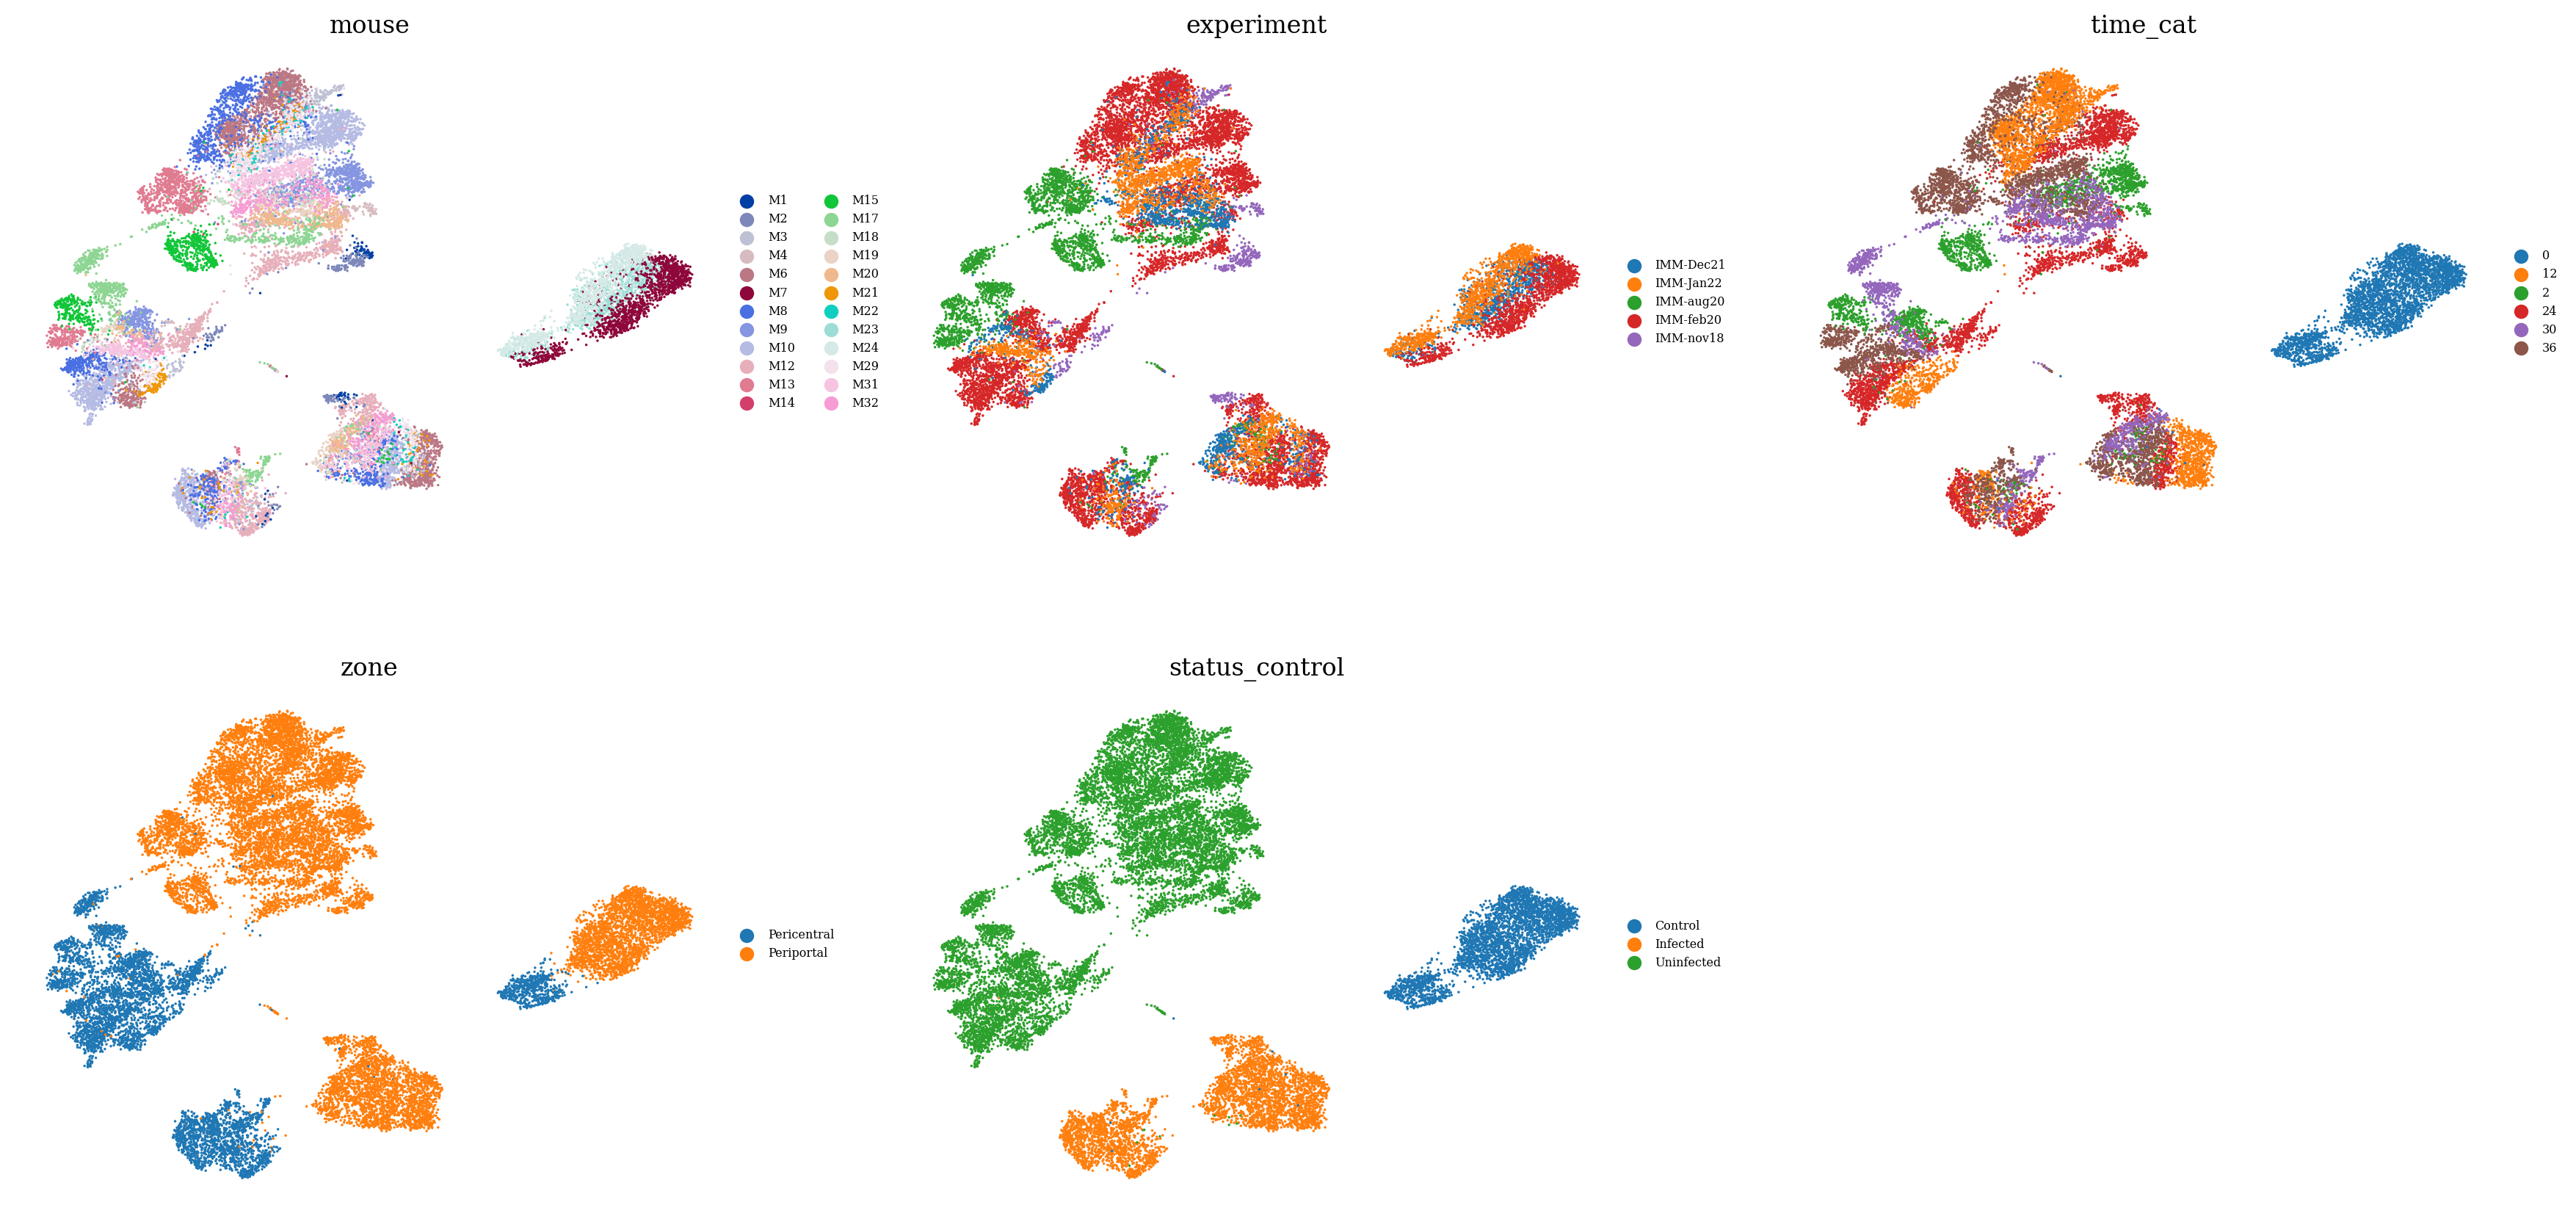

In [18]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

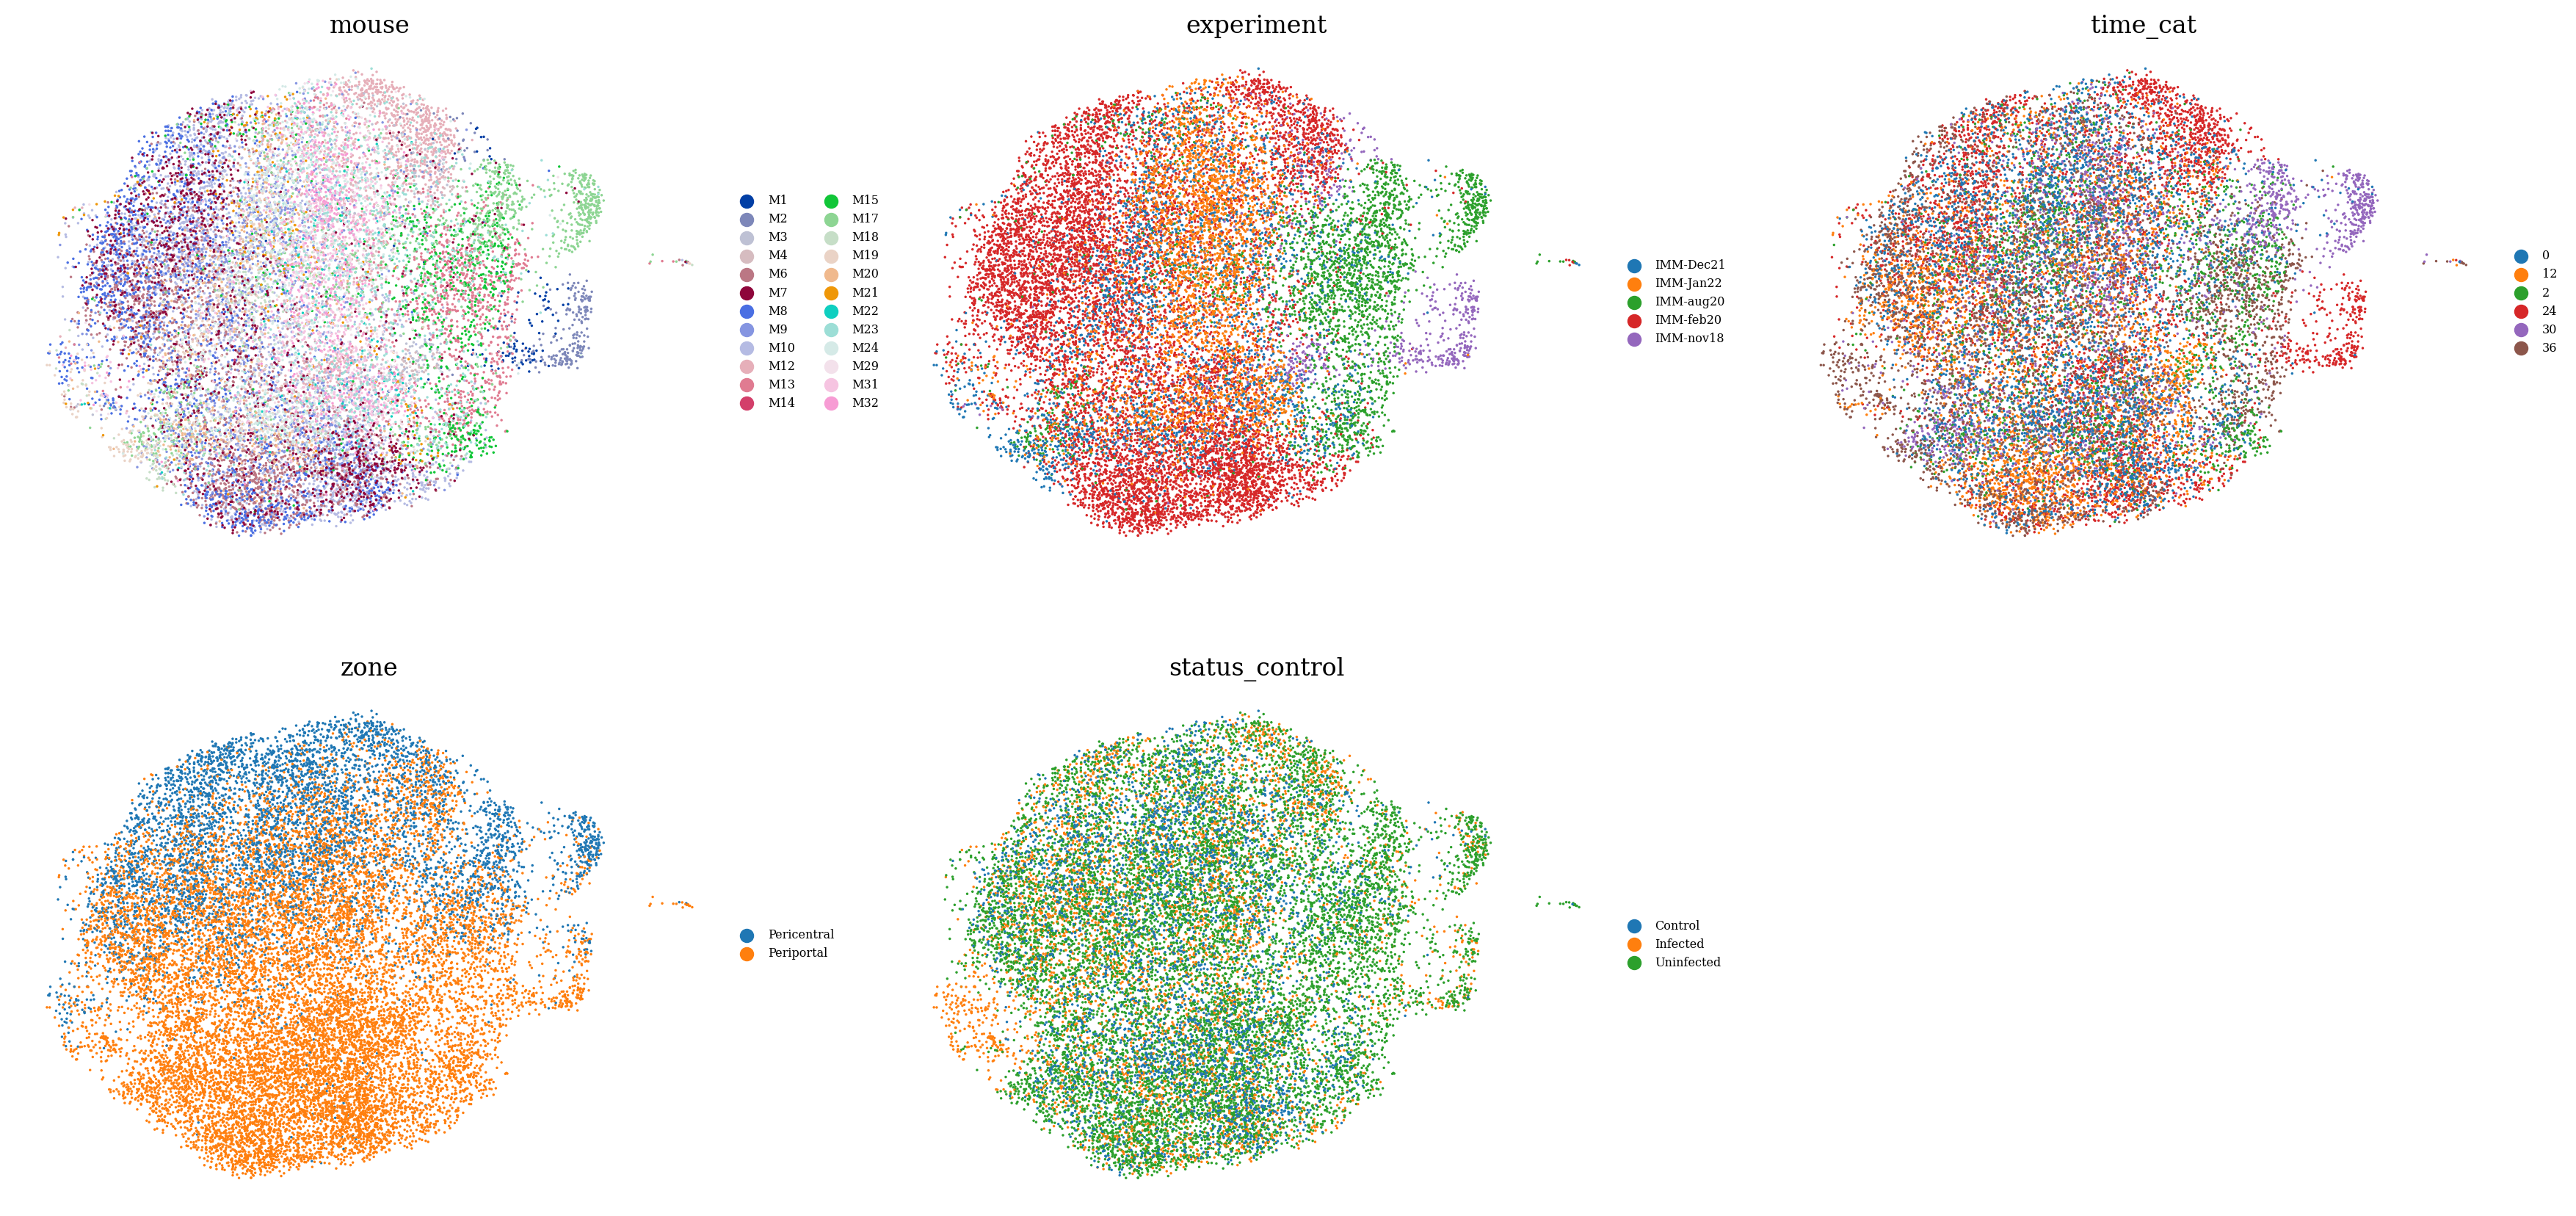

In [19]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [20]:
model.predict()

  0%|          | 0/596 [00:00<?, ?it/s]

  0%|          | 1/596 [00:00<04:00,  2.48it/s]

  0%|          | 2/596 [00:00<03:40,  2.69it/s]

  1%|          | 3/596 [00:01<03:35,  2.75it/s]

  1%|          | 4/596 [00:01<03:32,  2.78it/s]

  1%|          | 5/596 [00:01<03:31,  2.79it/s]

  1%|          | 6/596 [00:02<03:30,  2.80it/s]

  1%|          | 7/596 [00:02<03:29,  2.81it/s]

  1%|▏         | 8/596 [00:02<03:28,  2.82it/s]

  2%|▏         | 9/596 [00:03<03:27,  2.83it/s]

  2%|▏         | 10/596 [00:03<03:27,  2.82it/s]

  2%|▏         | 11/596 [00:03<03:27,  2.82it/s]

  2%|▏         | 12/596 [00:04<03:27,  2.82it/s]

  2%|▏         | 13/596 [00:04<03:27,  2.81it/s]

  2%|▏         | 14/596 [00:05<03:27,  2.81it/s]

  3%|▎         | 15/596 [00:05<03:26,  2.81it/s]

  3%|▎         | 16/596 [00:05<03:26,  2.81it/s]

  3%|▎         | 17/596 [00:06<03:25,  2.82it/s]

  3%|▎         | 18/596 [00:06<03:25,  2.82it/s]

  3%|▎         | 19/596 [00:06<03:24,  2.82it/s]

  3%|▎         | 20/596 [00:07<03:24,  2.82it/s]

  4%|▎         | 21/596 [00:07<03:25,  2.80it/s]

  4%|▎         | 22/596 [00:07<03:23,  2.81it/s]

  4%|▍         | 23/596 [00:08<03:23,  2.82it/s]

  4%|▍         | 24/596 [00:08<03:22,  2.82it/s]

  4%|▍         | 25/596 [00:08<03:22,  2.83it/s]

  4%|▍         | 26/596 [00:09<03:21,  2.83it/s]

  5%|▍         | 27/596 [00:09<03:21,  2.83it/s]

  5%|▍         | 28/596 [00:09<03:20,  2.83it/s]

  5%|▍         | 29/596 [00:10<03:21,  2.82it/s]

  5%|▌         | 30/596 [00:10<03:21,  2.81it/s]

  5%|▌         | 31/596 [00:11<03:21,  2.80it/s]

  5%|▌         | 32/596 [00:11<03:20,  2.81it/s]

  6%|▌         | 33/596 [00:11<03:20,  2.81it/s]

  6%|▌         | 34/596 [00:12<03:20,  2.81it/s]

  6%|▌         | 35/596 [00:12<03:20,  2.80it/s]

  6%|▌         | 36/596 [00:12<03:20,  2.79it/s]

  6%|▌         | 37/596 [00:13<03:19,  2.80it/s]

  6%|▋         | 38/596 [00:13<03:19,  2.79it/s]

  7%|▋         | 39/596 [00:13<03:19,  2.80it/s]

  7%|▋         | 40/596 [00:14<03:18,  2.80it/s]

  7%|▋         | 41/596 [00:14<03:17,  2.80it/s]

  7%|▋         | 42/596 [00:14<03:17,  2.81it/s]

  7%|▋         | 43/596 [00:15<03:16,  2.81it/s]

  7%|▋         | 44/596 [00:15<03:15,  2.82it/s]

  8%|▊         | 45/596 [00:16<03:15,  2.82it/s]

  8%|▊         | 46/596 [00:16<03:14,  2.83it/s]

  8%|▊         | 47/596 [00:16<03:14,  2.83it/s]

  8%|▊         | 48/596 [00:17<03:13,  2.83it/s]

  8%|▊         | 49/596 [00:17<03:13,  2.83it/s]

  8%|▊         | 50/596 [00:17<03:13,  2.82it/s]

  9%|▊         | 51/596 [00:18<03:13,  2.82it/s]

  9%|▊         | 52/596 [00:18<03:13,  2.82it/s]

  9%|▉         | 53/596 [00:18<03:12,  2.82it/s]

  9%|▉         | 54/596 [00:19<03:11,  2.82it/s]

  9%|▉         | 55/596 [00:19<03:11,  2.82it/s]

  9%|▉         | 56/596 [00:19<03:11,  2.82it/s]

 10%|▉         | 57/596 [00:20<03:11,  2.81it/s]

 10%|▉         | 58/596 [00:20<03:11,  2.81it/s]

 10%|▉         | 59/596 [00:20<03:10,  2.81it/s]

 10%|█         | 60/596 [00:21<03:10,  2.82it/s]

 10%|█         | 61/596 [00:21<03:09,  2.82it/s]

 10%|█         | 62/596 [00:22<03:09,  2.82it/s]

 11%|█         | 63/596 [00:22<03:09,  2.82it/s]

 11%|█         | 64/596 [00:22<03:09,  2.81it/s]

 11%|█         | 65/596 [00:23<03:09,  2.81it/s]

 11%|█         | 66/596 [00:23<03:08,  2.81it/s]

 11%|█         | 67/596 [00:23<03:08,  2.81it/s]

 11%|█▏        | 68/596 [00:24<03:07,  2.81it/s]

 12%|█▏        | 69/596 [00:24<03:07,  2.81it/s]

 12%|█▏        | 70/596 [00:24<03:06,  2.82it/s]

 15%|█▍        | 87/596 [00:25<00:24, 20.82it/s]

 18%|█▊        | 110/596 [00:25<00:10, 48.50it/s]

 22%|██▏       | 134/596 [00:25<00:05, 78.59it/s]

 27%|██▋       | 158/596 [00:25<00:04, 107.63it/s]

 31%|███       | 182/596 [00:25<00:03, 134.03it/s]

 34%|███▍      | 205/596 [00:25<00:02, 155.62it/s]

 38%|███▊      | 229/596 [00:25<00:02, 174.68it/s]

 42%|████▏     | 253/596 [00:25<00:01, 189.80it/s]

 46%|████▋     | 277/596 [00:25<00:01, 201.04it/s]

 51%|█████     | 301/596 [00:25<00:01, 209.37it/s]

 55%|█████▍    | 325/596 [00:26<00:01, 215.69it/s]

 59%|█████▊    | 349/596 [00:26<00:01, 220.08it/s]

 63%|██████▎   | 373/596 [00:26<00:00, 223.54it/s]

 67%|██████▋   | 397/596 [00:26<00:00, 225.93it/s]

 70%|███████   | 420/596 [00:26<00:00, 226.69it/s]

 74%|███████▍  | 443/596 [00:26<00:00, 227.56it/s]

 78%|███████▊  | 466/596 [00:26<00:00, 228.27it/s]

 82%|████████▏ | 490/596 [00:26<00:00, 228.98it/s]

 86%|████████▌ | 514/596 [00:26<00:00, 229.33it/s]

 90%|█████████ | 538/596 [00:26<00:00, 229.61it/s]

 94%|█████████▍| 562/596 [00:27<00:00, 229.90it/s]

 98%|█████████▊| 586/596 [00:27<00:00, 230.30it/s]

100%|██████████| 596/596 [00:27<00:00, 21.90it/s] 

In [21]:
pred_adata = adata[model.test_indices]
true = np.array(pred_adata.X)
pred = np.array(pred_adata.obsm["CPA_pred"])

In [22]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    print(start_ind, end_ind)
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind


0

32

32

64

64

96

96

128

128

160

160

192

192

224

224

256

256

288

288

320

320

352

352

384

384

416

416

448

448

480

480

512

512

544

544

576

576

608

608

640

640

672

672

704

704

736

736

768

768

800

800

832

832

864

864

896

896

928

928

960

960

992

992

1024

1024

1056

1056

1088

1088

1120

1120

1152

1152

1184

1184

1216

1216

1248

1248

1280

1280

1312

1312

1344

1344

1376

1376

1408

1408

1440

1440

1472

1472

1504

1504

1536

1536

1568

1568

1600

1600

1632

1632

1664

1664

1696

1696

1728

1728

1760

1760

1792

1792

1824

1824

1856

1856

1888

In [23]:
np.mean(r2s)

0.9508452016419779

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)